# Predict housing price

**Guidance**:
You'll find a data folder with quite a few JSON files.  In each of these files you'll find data for housing sales in the US.  To wrangle the data, try iterating over each file, loading it, and storing it in memory.

Your tasks are as follows:
1. Load the data from the provided files (in the `data/` directory) into a Pandas dataframe
2. Explore, clean and preprocess your data to make it ready for ML Modelling
3. (Stretch) Explore some outside data sources - is there any other information you could join to your data that might be helpful to predict housing prices?
4. Perform EDA on your data to help understand the distributions and relationships between your variables
5. Save your finalized dataframes (`X_train`, `y_train`, `X_test` and `y_test`) as .csv's in your `data/` directory. You may want to make a `processed/` subfolder.

**Table of contents:**
* Import libraries
* A- Load data
* B- Feature Engineering - 'tags' handling
* C- Preliminary exploration on dataset
* D- Data Cleaning
* E- Explore data by descriptive statistics
* F- Explore data by visualization
* G- Outlier Handling
* H- Data Splitting
* I- DataTransfromation for modelling
* J- Save data for modelling

# Import libraries

In [1]:
import pandas as pd
pd.set_option('display.float_format', '{:.0f}'.format)  #figures are displayed without using scientific notation
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')
sns.set_palette("husl")

import os
import json
from pprint import pprint

from functions_visualization import *
from functions_preprocessing import *

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from category_encoders import TargetEncoder

# A - Load data

### # Load one file first to see what type of data we are dealing with and what attributes it has

In [2]:
with open("../data/AK_Juneau_0.json") as f:
    nested_data = json.load(f)
    
# Print out the result
pprint(nested_data)

{'data': {'count': 8,
          'results': [{'branding': [{'name': 'EXP Realty LLC - Southeast '
                                             'Alaska',
                                     'photo': None,
                                     'type': 'Office'}],
                       'community': None,
                       'description': {'baths': 2,
                                       'baths_1qtr': None,
                                       'baths_3qtr': None,
                                       'baths_full': 2,
                                       'baths_half': None,
                                       'beds': 3,
                                       'garage': 1,
                                       'lot_sqft': 10454,
                                       'name': None,
                                       'sold_date': '2023-09-18',
                                       'sold_price': None,
                                       'sqft': 1821,
                      

### # Iterate through all the JSON files in the directory, extract the necessary information, and create an aggregate DataFrame. 

In [3]:
# Get a list of all JSON files in the directory
folder_path = "../data"
json_files = [file for file in os.listdir(folder_path) if file.endswith('.json')]

# Read data of JSON files and put it into a list
data_list = []
for json_file in json_files:
    with open(os.path.join(folder_path, json_file), 'r') as file:
        data = json.load(file)
        data_list.append(data)
#pprint(data_list)    # Print out the result if want to see

In [4]:
# Loop through all data and extract necessary information
extracted_data =[]

for data in data_list:
    results = data['data']['results']
    for result in results:
        extracted_data.append(def_Extract_Info(result))

In [5]:
# Create DataFrame
df = pd.DataFrame(extracted_data)

In [6]:
# Check the shape of DataFrame
df.shape

(8159, 21)

In [7]:
# Take a look at the first 3 rows of the dataset
df.head(3)

,sale_price,list_price,price_reduced_amount,status,address,city,postal_code,state,state_code,latitude,...,year_built,sub_type,type,lot_sqft,living_sqft,number_of_stories,number_of_baths,number_of_beds,number_of_garages,tags
0,NaN,554950,45000,sold,9453 Herbert Pl,Juneau,99801,Alaska,AK,58,...,1963,None,single_family,10454,1821,NaN,2,3,1,"[carport, community_outdoor_space, cul_de_sac,..."
1,NaN,NaN,NaN,sold,8477 Thunder Mountain Rd,Juneau,99801,Alaska,AK,NaN,...,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None
2,NaN,NaN,NaN,sold,4515 Glacier Hwy,Juneau,99801,Alaska,AK,NaN,...,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None


In [8]:
# Take a look at the last 3 rows of the dataset
df.tail(3)

,sale_price,list_price,price_reduced_amount,status,address,city,postal_code,state,state_code,latitude,...,year_built,sub_type,type,lot_sqft,living_sqft,number_of_stories,number_of_baths,number_of_beds,number_of_garages,tags
8156,162250,133000,NaN,sold,238 Oakwood Rd,Charleston,25314,West Virginia,WV,38,...,NaN,None,single_family,65340,1470,NaN,1,3,NaN,"[basement, big_lot]"
8157,63800,75000,NaN,sold,408 Lee St W,Charleston,25302,West Virginia,WV,38,...,NaN,None,single_family,NaN,NaN,NaN,0,0,NaN,[rental_property]
8158,115500,112600,NaN,sold,625 Wood Rd,Charleston,25302,West Virginia,WV,38,...,1950,None,single_family,52272,3858,NaN,2,3,NaN,"[central_air, garage_1_or_more, basement, sing..."


**Note:** Values of 'tags' features are lists ---> need to address.

# _______________
# B - Feature Engineering: 'tags' handling

In [9]:
# Create new features from "tags" feature
df_tags_dummies = df['tags'].str.join('|').str.get_dummies()
df_tags_dummies.head(3)

,baseball,basement,basketball,basketball_court,beach,beautiful_backyard,big_bathroom,big_lot,big_yard,boat_dock,...,views,volleyball,washer_dryer,water_view,waterfront,well_water,white_kitchen,wine_cellar,wooded_land,wrap_around_porch
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Note: 
There are a lot of categorical variables that are generated from _tags_ column (155 columns). We are going to get rid of "tags" attributes that have a low frequency.

In [10]:
# Apply defined-function
df = def_Encode_Tags(df, threshold=10)

print("Shape of DataFrame after creating new features from 'tags' column: ", df.shape)

Shape of DataFrame after creating new features from 'tags' column:  (8159, 46)


In [11]:
### AUDIT - CHECK ERROR for "Is each cell one value, or do some cells have lists/dicts?"

# Create a binary DataFrame indicating out the index of dict elements
list_dict_mask = df.applymap(lambda x: isinstance(x, (list, dict)))

# Create a list of Columns containing dict/list
columns_with_list_dict = list_dict_mask.any(axis=0)

# Implement the check
if len(columns_with_list_dict[columns_with_list_dict].index.tolist()) == 0:  # empty result
    print("All cells in dataset do not contain lists or dicts.")
else:
    print("Columns with list/dict values:")
    print(columns_with_list_dict[columns_with_list_dict].index.tolist())

    # Show the rows containing dict/list
    rows_with_list_dict = list_dict_mask.any(axis=1)
    print("Rows with list/dict values:")
    print(rows_with_list_dict[rows_with_list_dict].index.tolist())

All cells in dataset do not contain lists or dicts.


In [12]:
# Save dataframe into CSV file
df.to_csv("../data/csv_files/extracted_data.csv", index=False)

# _______________
# C - Preliminary exploration on dataset

In [13]:
print(f'Dataset contains {df.shape[0]} rows, {df.shape[1]} columns.')

Dataset contains 8159 rows, 46 columns.


In [14]:
# List out the features/columns of dataset
df.columns

Index(['sale_price', 'list_price', 'price_reduced_amount', 'status', 'address',
       'city', 'postal_code', 'state', 'state_code', 'latitude', 'longitude',
       'year_built', 'sub_type', 'type', 'lot_sqft', 'living_sqft',
       'number_of_stories', 'number_of_baths', 'number_of_beds',
       'number_of_garages', 'basement', 'big_lot', 'central_air',
       'central_heat', 'city_view', 'community_outdoor_space',
       'community_security_features', 'dining_room', 'dishwasher',
       'family_room', 'fenced_yard', 'fireplace', 'floor_plan', 'forced_air',
       'garage_1_or_more', 'garage_2_or_more', 'hardwood_floors',
       'laundry_room', 'new_roof', 'recreation_facilities', 'rental_property',
       'shopping', 'single_story', 'two_or_more_stories', 'view',
       'washer_dryer'],
      dtype='object')

In [15]:
# Take a look at the last 5 rows of the dataset
df.tail()

,sale_price,list_price,price_reduced_amount,status,address,city,postal_code,state,state_code,latitude,...,hardwood_floors,laundry_room,new_roof,recreation_facilities,rental_property,shopping,single_story,two_or_more_stories,view,washer_dryer
8154,99000,98000,NaN,sold,1008 Oakmont Rd,Charleston,25314,West Virginia,WV,38,...,0,0,1,0,0,0,0,1,0,0
8155,29700,49999,NaN,sold,1041 Temple St,Charleston,25387,West Virginia,WV,38,...,0,0,0,0,0,0,0,0,0,0
8156,162250,133000,NaN,sold,238 Oakwood Rd,Charleston,25314,West Virginia,WV,38,...,0,0,0,0,0,0,0,0,0,0
8157,63800,75000,NaN,sold,408 Lee St W,Charleston,25302,West Virginia,WV,38,...,0,0,0,0,1,0,0,0,0,0
8158,115500,112600,NaN,sold,625 Wood Rd,Charleston,25302,West Virginia,WV,38,...,0,0,0,0,0,0,1,0,0,0


In [16]:
# Learn the dtypes of columns and how many non-null values are there in those columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8159 entries, 0 to 8158
Data columns (total 46 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   sale_price                   6716 non-null   float64
 1   list_price                   7721 non-null   float64
 2   price_reduced_amount         2484 non-null   float64
 3   status                       8159 non-null   object 
 4   address                      8144 non-null   object 
 5   city                         8154 non-null   object 
 6   postal_code                  8159 non-null   object 
 7   state                        8159 non-null   object 
 8   state_code                   8159 non-null   object 
 9   latitude                     7909 non-null   float64
 10  longitude                    7909 non-null   float64
 11  year_built                   7316 non-null   float64
 12  sub_type                     1427 non-null   object 
 13  type              

In [17]:
# learn the distinct values in each feature
df.nunique()

sale_price                      738
list_price                      711
price_reduced_amount            145
status                            1
address                        1789
city                            101
postal_code                     492
state                            45
state_code                       45
latitude                       1729
longitude                      1728
year_built                      147
sub_type                          2
type                             11
lot_sqft                        743
living_sqft                    1119
number_of_stories                 7
number_of_baths                  10
number_of_beds                   13
number_of_garages                 9
basement                          2
big_lot                           2
central_air                       2
central_heat                      2
city_view                         2
community_outdoor_space           2
community_security_features       2
dining_room                 

### Change data type

In [18]:
list_num_cols = ['sale_price','list_price','price_reduced_amount','latitude','longitude','year_built','lot_sqft','living_sqft']
list_total_cols = df.columns.tolist()
list_cat_cols = [col for col in list_total_cols if col not in list_num_cols]  # get the remaining cols

In [19]:
for col in list_cat_cols:
    df[col] = df[col].astype('object')

# Check dtypes of columns again
df.dtypes

sale_price                     float64
list_price                     float64
price_reduced_amount           float64
status                          object
address                         object
city                            object
postal_code                     object
state                           object
state_code                      object
latitude                       float64
longitude                      float64
year_built                     float64
sub_type                        object
type                            object
lot_sqft                       float64
living_sqft                    float64
number_of_stories               object
number_of_baths                 object
number_of_beds                  object
number_of_garages               object
basement                        object
big_lot                         object
central_air                     object
central_heat                    object
city_view                       object
community_outdoor_space  

In [20]:
# Explore data by descriptive statistics for numerical features
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sale_price,6716,412605,699431,308,191000,314000,470000,27065000
list_price,7721,434158,551493,1,209000,325000,499900,12500000
price_reduced_amount,2484,24427,71624,100,6000,10100,20000,2015999
latitude,7909,39,4,21,36,40,42,58
longitude,7909,-92,16,-158,-105,-89,-79,-71
year_built,7316,1969,35,1828,1950,1975,1997,2024
lot_sqft,6991,251095,5823820,0,4953,7841,12632,167662440
living_sqft,7323,1934,1339,120,1258,1635,2264,32106


#### Comment:
1. Very large dispersion (A wide range) in `sale_price`,`list_price`,`lot_sqft`,`living_sqft` columns ---> indicate that dataset has many outliers or exception.
2. There are some unusual values in columns such as `sale_price`, `list_price`, `lot_sqft`: 
- `sale_price` :  The minimum value 308 is extremely low and may be an input error.
- `list_price` : The minimum value is 1, which is highly unusual and may be a data error. The maximum value is also high but lower than the sale_price, which may make sense since the sale price can often be higher than the list price due to competition.
- `lot_sqft` : min=0 --> may be an exception or an input error.

In [21]:
# Replace value of 0 with NaN in order to handle it in missing-values section
df['lot_sqft'].replace(0.0, np.nan, inplace=True)

# _______________
# D - Data Cleaning

## 1. Duplicates

In [22]:
# Check for duplicated rows
df.duplicated().sum() 

6364

In [23]:
# Check for duplicates based on "address" column
df.duplicated(subset="address").sum()

6369

#### Comment: 
Data has 6364 duplicated rows; particularly, this data has 6369 duplicated address.

In [24]:
# Handle duplicates
df.drop_duplicates(keep='first', inplace=True)

# Check for duplicated rows again
df.duplicated().sum() 

0

In [25]:
# Check for duplicated addresses again
df.duplicated(subset="address").sum()

5

In [26]:
# Show duplicates based on "address" column
df[df.duplicated(subset="address")]

,sale_price,list_price,price_reduced_amount,status,address,city,postal_code,state,state_code,latitude,...,hardwood_floors,laundry_room,new_roof,recreation_facilities,rental_property,shopping,single_story,two_or_more_stories,view,washer_dryer
2093,2016000,1,2015999,sold,140th St,Boone,50036,Iowa,IA,NaN,...,0,0,0,0,1,0,0,0,0,0
2380,10000,NaN,NaN,sold,565 W Elliott Ave,Springfield,62702,Illinois,IL,40,...,0,0,0,0,0,0,0,0,0,0
3412,1500000,1550000,150000,sold,107 Conduit St,Annapolis,21401,Maryland,MD,39,...,0,0,0,0,1,1,0,0,0,1
4155,NaN,5500000,NaN,sold,None,Helena,59601,Montana,MT,NaN,...,0,0,0,0,0,0,0,0,0,0
4795,685000,685000,NaN,sold,None,Robbinsville,08691,New Jersey,NJ,40,...,0,0,0,0,0,1,0,1,0,0


#### Comment:
The actual result did not find any data rows with duplicated addresses.
* The first three rows: result by manually checking as above, they are not really duplicated.
* The last two rows: empty or null values in the "address" column, Pandas considers them duplicates of each other; but result by manually checking as above, they are not duplicated.

In [27]:
# Check data shape again after dropping duplicated rows
df.shape

(1795, 46)

## 2. Drop columns that aren't needed
* Drop 'status' column because it has only 1 type of value (Sold) we have the sold price already.
* Drop 'address' column because we will use longitude and latitude, and also it does not provide mathematical significance towards pipeline.
* Drop 'postal_code' column because we will use longitude and latitude.
* Drop 'state_code' because it overlaps with 'state' column.
* Drop 'forced_air' because this overlaps with 'central_heat'.
* Drop 'big_lot' because this overlaps with 'lot_sqft'.
* Drop 'dishwasher','washer_dryer' : these are standard features, these do not add significant unique value to house price.
* Drop 'family_room','laundry_room','dining_room': these rooms add functionality and space, which can be important for larger families, but these overlap with 'living_sqft'.

In [28]:
df['status'].unique()  # 'status' column has only 1 type of value.

array(['sold'], dtype=object)

In [29]:
# Implement dropping
df = df.drop(['status','address', 'postal_code','state_code', 'forced_air', 'big_lot', 
              'dishwasher','washer_dryer','laundry_room', 'dining_room', 'family_room'], axis=1)

In [30]:
# Check data shape again after dropping duplicated rows
df.shape

(1795, 35)

## 3. Clean property type feature

In [31]:
df['type'].nunique()   # there are 11 property type in dataset

11

In [32]:
# Check the number of occurrence of each property type
df['type'].value_counts()

type
single_family                  1200
condos                          182
townhomes                       124
multi_family                    118
land                             95
mobile                           44
condo                            15
apartment                         4
other                             3
duplex_triplex                    1
condo_townhome_rowhome_coop       1
Name: count, dtype: int64

In [33]:
df['type'].unique()

array(['single_family', None, 'condos', 'mobile', 'land', 'townhomes',
       'multi_family', 'apartment', 'condo', 'other', 'duplex_triplex',
       'condo_townhome_rowhome_coop'], dtype=object)

In [34]:
df['sub_type'].unique()

array([None, 'condo', 'townhouse'], dtype=object)

In [35]:
# Filter to take a look which sub_type goes along with 'condo_townhome_rowhome_coop' type
filtered_df = df[df['type'].isin(['condo_townhome_rowhome_coop'])]
type_subtype_condo_townhome_rowhome_coop= filtered_df[['type', 'sub_type']]
type_subtype_condo_townhome_rowhome_coop 

,type,sub_type
6697,condo_townhome_rowhome_coop,townhouse


#### Comment: There is overlap in values of property type

### Solution:
Based on domain knowledge and the above result, we will:
1. Replace values of 'apartment', 'condo', 'condos' in `type` column with value of 'apartment'.
2. Replace values of 'townhomes', 'condo_townhome_rowhome_coop' in `type` column with value of 'townhouse'.
3. Replace values of 'duplex_triplex' in `type` column with value of 'multi_family'.
4. Delete rows where contain **'other'** value in `type` because it has have a tiny frequency and is vague.
5. Moreover, we decide to remove **'land'** property `type` out the dataset
    - because we define the objective as predicting _housing sale price_, not as _general real estate price_.
    - Keeping the property type 'land' in the dataset may not be suitable because 'land' often does not have the same characteristics as a house (e.g. number of bedrooms, number of bathrooms, living floor area, year built, etc.), and its selling price may be affected by other factors.
    - So, removing the "land" property type from the dataset will help the model focus on similar asset types, making forecasting more accurate.

In [36]:
# Replace values in the 'type' column
df['type'] = df['type'].replace({'condo': 'apartment',
                                 'condos': 'apartment',
                                 'townhomes': 'townhouse',
                                 'condo_townhome_rowhome_coop': 'townhouse',
                                 'duplex_triplex': 'multi_family'})

# Remove rows where contain 'other' value in `type` column
# df = df[df['type'] != 'other']
# df = df[df['type'] != 'land']
df = df.drop(df[(df['type'].isin(['other','land']))].index)

# Drop 'sub_type' column because it becomes redundant and mostly null --> do not provide a higher significance.
df = df.drop('sub_type', axis=1)

In [37]:
# Check property types again
df['type'].unique()

array(['single_family', None, 'apartment', 'mobile', 'townhouse',
       'multi_family'], dtype=object)

## 4. Missing values

In [38]:
# Check for missing values
df.isnull().any().sum() 

14

**Comment**: Dataset has 14 features having null values.

In [39]:
# df.isnull().sum()

In [40]:
# List features having null values along with its percentage
ser_null = df.isnull().sum()
totalrows = df.shape[0]
ser_percent = round(ser_null/totalrows*100,2)
df_null = pd.concat([ser_null, ser_percent], axis=1, keys=['TotalNulls', 'Percent %']).sort_values(by='Percent %', ascending=False)
df_null = df_null[df_null['TotalNulls']>0]

pd.reset_option('display.float_format')
df_null

,TotalNulls,Percent %
price_reduced_amount,1162,68.47
number_of_garages,720,42.43
number_of_stories,326,19.21
sale_price,296,17.44
lot_sqft,222,13.08
living_sqft,89,5.24
year_built,88,5.19
list_price,63,3.71
number_of_beds,49,2.89
number_of_baths,35,2.06


In [41]:
# Take a closer look at missing values for 'type' column
df[df['type'].isnull()]

,sale_price,list_price,price_reduced_amount,city,state,latitude,longitude,year_built,type,lot_sqft,...,garage_1_or_more,garage_2_or_more,hardwood_floors,new_roof,recreation_facilities,rental_property,shopping,single_story,two_or_more_stories,view
1,NaN,NaN,NaN,Juneau,Alaska,NaN,NaN,NaN,None,NaN,...,0,0,0,0,0,0,0,0,0,0
2,NaN,NaN,NaN,Juneau,Alaska,NaN,NaN,NaN,None,NaN,...,0,0,0,0,0,0,0,0,0,0
3,NaN,NaN,NaN,Juneau,Alaska,NaN,NaN,NaN,None,NaN,...,0,0,0,0,0,0,0,0,0,0
4,NaN,NaN,NaN,Juneau,Alaska,NaN,NaN,NaN,None,NaN,...,0,0,0,0,0,0,0,0,0,0
2367,359900.0,NaN,NaN,Springfield,Illinois,NaN,NaN,NaN,None,NaN,...,0,0,0,0,0,0,0,0,0,0
2551,162000.0,NaN,NaN,Indianapolis,Indiana,NaN,NaN,NaN,None,NaN,...,0,0,0,0,0,0,0,0,0,0
2557,294988.0,NaN,NaN,Indianapolis,Indiana,NaN,NaN,NaN,None,NaN,...,0,0,0,0,0,0,0,0,0,0
2561,349990.0,NaN,NaN,Indianapolis,Indiana,NaN,NaN,NaN,None,NaN,...,0,0,0,0,0,0,0,0,0,0


In [42]:
# Take a closer look at missing values for 'city' column
df[df['city'].isnull()]

,sale_price,list_price,price_reduced_amount,city,state,latitude,longitude,year_built,type,lot_sqft,...,garage_1_or_more,garage_2_or_more,hardwood_floors,new_roof,recreation_facilities,rental_property,shopping,single_story,two_or_more_stories,view
5624,470000.0,495000.0,NaN,None,Ohio,40.102921,-83.081039,1971.0,single_family,34404.0,...,1,1,0,0,0,0,0,1,0,0


### Solution:
1. Delete whole column for `price_reduced_amount` because of too much missing values (~70%); moreover, it does not affect house price.
2. Delete whole column for `list_price`because it will be too close to the sale price (--> overlap, redundant information) even though its missing values are not too much (~3.71%).
3. Delete rows where contain missing values in `sale_price` because this is our target variable. We can make a prediction if it is missed.
4. Delete rows where contain missing values in `type` because  its missing values are very low (only 0.47%) and it's not easy to deduce from other features in these rows due to all of them are null except sale price.
5. With `city`: Fill missing values with value "Columbus" because we can deduce from latitude, longitude = 40.102921,-83.081039.
   
6. With `number_of_garages`: Fill missing values based on the following rule:
    * If its property type is **apartment/mobile**: --> set 'number_of_garages' to 0.
    * If its property type is **not** apartment/mobile  AND _garage_2_or_more_ is 1 (Yes): --> set 'number_of_garages' to 2.
    * If its property type is **not** apartment/mobile  AND _garage_1_or_more_ is 1 (Yes): --> set 'number_of_garages' to 1.
    * Otherwise, its property type is **not** apartment/mobile  AND BOTH _garage_1_or_more_ and _garage_2_or_more_ are 0 (No): --> set 'number_of_garages' to 0.

7. With `number_of_stories`: Fill missing values based on the following rule:
    * If the property type is **'mobile'** --> set 'number_of_stories' to 0.
    * If the property type is **not** 'mobile'  AND  'two_or_more_stories' is 1 (yes) --> set 'number_of_stories' to 2.
    * If the property type is **not** 'mobile'  AND  'single_story' is 1 (yes)        --> set 'number_of_stories' to 1.
    * Otherwise, the property type is **not** 'mobile'  AND both  'two_or_more_stories' and 'single_story is 0 (no) --> set 'number_of_stories' to 1.
  
8. With `lat`,`lon` features: Use backfill n/a method.
   
9. With `year_built` feature: Fill missing values using the **median** year built **of each property type.**
      
10. With `living_sqft`, `lot_sqft`, features:  Use regression models to predict missing values based on the other features (such as property type and other related features: number_of_stories, number_of_beds, number_of_baths, number_of_garages, etc.). Using rows with non-missing values for training with RandomForestRegressor model, then predicting missing values using the trained model.

11. With `number_of_beds`, `number_of_baths` features:  Use classification models to predict missing values based on the other features (such as property type and other related features: living_sqft, lot_sqft, number_of_stories, number_of_garages, etc.). Using rows with non-missing values for training with RandomForestClassifier model, then predicting missing values using the trained model.

In [43]:
# 1,2: Handling missing values for 'price_reduced_amount','list_price'
df.drop(['price_reduced_amount','list_price'], axis=1, inplace=True)

# 3,4:  Handling missing values for 'sale_price', 'type'
df.dropna(subset=['sale_price','type'], axis=0, inplace=True)  

# 5: Handling missing values for 'city'
df['city'].fillna('Columbus', inplace=True)

In [44]:
# 6:  Handling missing values for 'number_of_garages'
df = def_Impute_Number_Of_Garages(df)            # Apply the defined-function to fill missing 'number_of_garages' values
df = df.drop(['garage_1_or_more', 'garage_2_or_more'], axis=1)  # Drop 'garage_2_or_more' and 'garage_1_or_more' columns 
                                                                # because we already had 'number_of_garages' so they became to be redundant information.

In [45]:
# 7:  Handling missing values for 'number_of_stories'
df = def_Impute_Number_Of_Stories(df)           #  Apply the defined-function to fill missing 'number_of_stories' values
df = df.drop(['single_story', 'two_or_more_stories'], axis=1)   # Drop 'garage_2_or_more' and 'garage_1_or_more' columns
                                                               # because we already had number_of_stories so that they became to be redundant information.

In [46]:
# 8. Handling missing values for 'latitude', 'longitude' 
df['latitude'].fillna(method='backfill', inplace=True)
df['longitude'].fillna(method='backfill', inplace=True)

In [47]:
# 9. Handling missing values for 'year_built'
df = def_Impute_Year_Built(df)     #  Apply the defined-function

In [48]:
# 10a. Handling missing values for `living_sqft`
features = ['number_of_stories', 'number_of_beds', 'number_of_baths', 'number_of_garages', 'basement', 'lot_sqft', 'type'] 
                                                                         # Select the features for prediction of missing values
df['living_sqft'] = def_Regression_Impute(df, 'living_sqft', features)   #  Apply the defined-function regression imputation

In [49]:
# 10b. Handling missing values for `lot_sqft`
features = ['number_of_stories', 'number_of_beds', 'number_of_baths', 'number_of_garages', 'basement', 'living_sqft', 'type']
                                                                    # Select the features for prediction of missing values 
df['lot_sqft'] = def_Regression_Impute(df, 'lot_sqft', features)    #  Apply the defined-function regression imputation

In [50]:
# 11a:  Handling missing values for 'number_of_beds'
features = ['number_of_stories', 'number_of_baths', 'number_of_garages', 'basement', 'living_sqft', 'lot_sqft', 'type']
                                                                                  # Select the features for prediction of missing values 
df['number_of_beds'] = def_Classification_Impute(df, 'number_of_beds', features)  #  Apply the defined-function classification imputation

In [51]:
# 11b:  Handling missing values for 'number_of_baths' 
features = ['number_of_stories', 'number_of_beds', 'number_of_garages', 'basement', 'living_sqft', 'lot_sqft', 'type']
                                                                                    # Select the features for prediction of missing values 
df['number_of_baths'] = def_Classification_Impute(df, 'number_of_baths', features)  #  Apply the defined-function classification imputation

In [52]:
# Check missing values again to make sure it worked properly
df.isnull().any().sum() 

0

In [53]:
# Check the shape
df.shape

(1397, 28)

In [54]:
# Reset index for DataFrame
df = df.reset_index(drop=True)

# Save dataframe into CSV file
df.to_csv("../data/csv_files/cleaned_data_WITH_outliers.csv", index=False)

# _______________
# E - Explore data by descriptive statistics

In [55]:
pd.set_option('display.float_format', '{:.0f}'.format)  #figures are displayed without using scientific notation

In [56]:
## For numerical features
df.describe(include=['int','float']).T

,count,mean,std,min,25%,50%,75%,max
sale_price,1397,430795,882110,2500,200000,315000,475000,27065000
latitude,1397,39,4,21,36,40,42,47
longitude,1397,-90,16,-158,-97,-85,-77,-71
year_built,1397,1967,35,1828,1948,1970,1995,2023
lot_sqft,1397,153139,3804664,436,4704,7784,12197,139043520
living_sqft,1397,1913,1303,120,1236,1635,2230,32106


In [57]:
# For categorical data
df.describe(include=['object','category']).T

,count,unique,top,freq
city,1397,80,Raleigh,46
state,1397,35,Wisconsin,46
type,1397,5,single_family,990
number_of_stories,1397,8,1,802
number_of_baths,1397,10,2,609
number_of_beds,1397,13,3,640
number_of_garages,1397,10,0,574
basement,1397,2,0,759
central_air,1397,2,1,754
central_heat,1397,2,0,1155


### Comment:
Compared to initial descriptive summary, the significantly unusual values are disappeared in now's descriptive. Howerver, the very large dispersion (wide range) in columns is still exist ---> dataset has many outliers or exception.

# _______________
# F - Explore data by visualization

In [58]:
# Define numerical and categorical features
numerical_cols = df.select_dtypes(include=['int','float']).columns
categorical_cols = df.select_dtypes(include=['object','category']).columns 

print("Numerical features include:\n", numerical_cols)
print("Total:", len(numerical_cols))
print("-"*10)
print("Categorical features include:\n", categorical_cols)
print("Total:", len(categorical_cols))

Numerical features include:
 Index(['sale_price', 'latitude', 'longitude', 'year_built', 'lot_sqft',
       'living_sqft'],
      dtype='object')
Total: 6
----------
Categorical features include:
 Index(['city', 'state', 'type', 'number_of_stories', 'number_of_baths',
       'number_of_beds', 'number_of_garages', 'basement', 'central_air',
       'central_heat', 'city_view', 'community_outdoor_space',
       'community_security_features', 'fenced_yard', 'fireplace', 'floor_plan',
       'hardwood_floors', 'new_roof', 'recreation_facilities',
       'rental_property', 'shopping', 'view'],
      dtype='object')
Total: 22


## 1. Explore the Numerical Variables

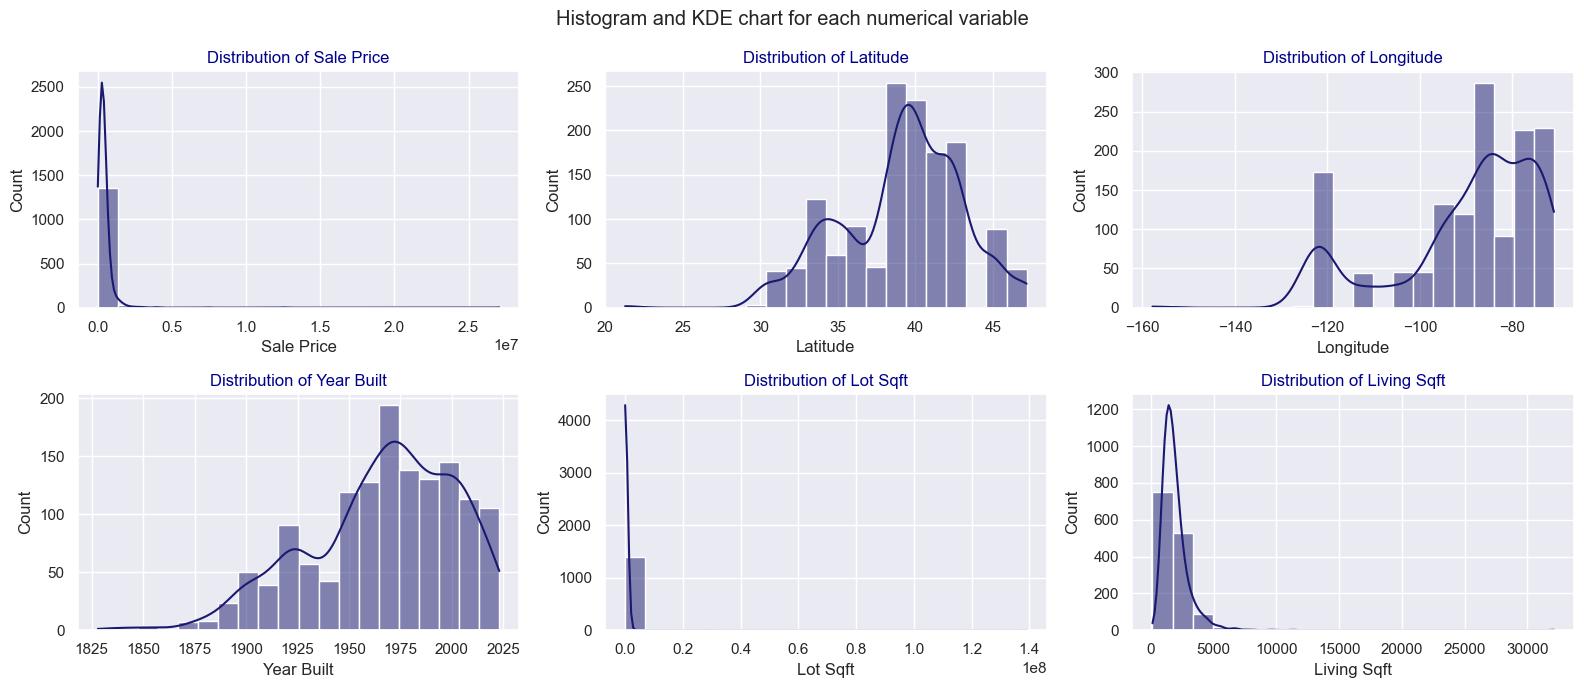

In [59]:
# Plot histogram for numerical features
def_Draw_Histograms_Univariate(df, numerical_cols, nrows=2, ncols=3)

***Insights on the distribution with outliers***
- The `sale_price`, `lot_sqft` and `living_sqft` are heavily right skewed giving insight to the cause of this distribution as outliers in the data. The `sale_price` has max value of *27065000* which is skewing the data.
- Whereas `latitude`,`longitude` and `year_built` shows left skewness and the things that can be visualized are,
    - Most of the houses which are in our data are built between 1950 - 2024.
    - The Skewness in `latitude` and `longitude` shows that the data is focusing more on certain location ranges than the other. These corresponds to the location of the house we have in data.

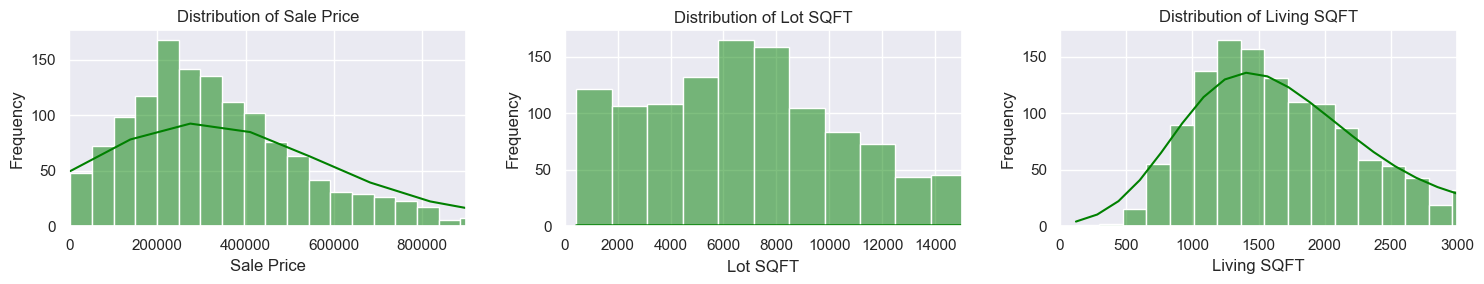

In [60]:
# Plot histogram for 3 numerical features
fig,ax = plt.subplots(figsize=(15,3),ncols=3,nrows=1)


sns.histplot(df['sale_price'],color='green',kde=True,linewidth=1,ax=ax[0])
ax[0].set_xlabel('Sale Price')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Distribution of Sale Price')
ax[0].set_xlim(0, 900000)

sns.histplot(df['lot_sqft'],color='green',kde=True,linewidth=1,ax=ax[1])
ax[1].set_xlabel('Lot SQFT')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Distribution of Lot SQFT')
ax[1].set_xlim(0, 15000)

sns.histplot(df['living_sqft'],color='green',kde=True,linewidth=1,ax=ax[2])
ax[2].set_xlabel('Living SQFT')
ax[2].set_ylabel('Frequency')
ax[2].set_title('Distribution of Living SQFT')
ax[2].set_xlim(0, 3000)


plt.tight_layout()
plt.show()

***Insights on the distribution with X and Y limits***
- `sale_price` : It is not a normal distribution and slightly right skewed which means we have more house in the mid price range. This explains what type of houses and prices can survive in the respective locations and also what is the potential of a 800,000 Home for example.
- `lot_SQFT` : This is a uniform distibution with higher peaks from 5000- 8000 which means our data has more house within this Lot-Sqft range.
- `living_SQFT` : This is a uniform distibution with higher peaks from 1000- 2000 which means our data has more house within this Lot-Sqft range.

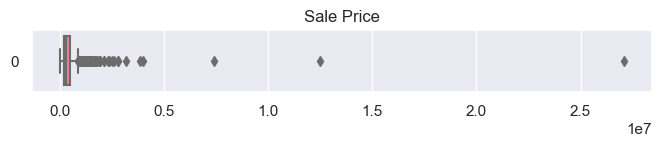

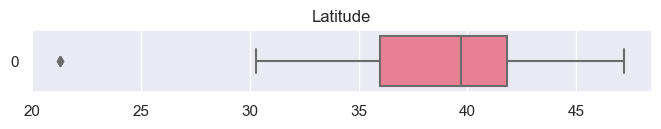

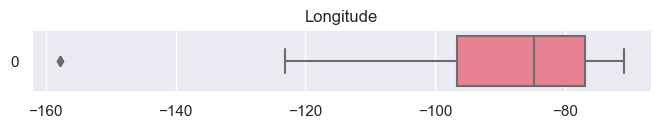

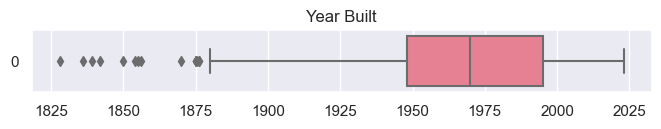

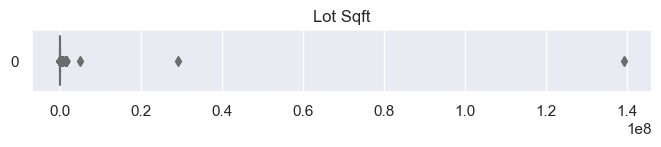

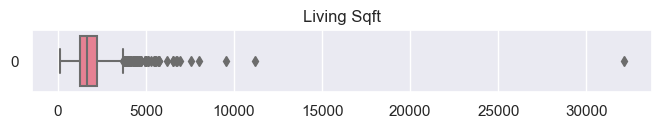

In [61]:
# Outliers Detection using Boxplot
for col in df.select_dtypes(include=np.number).iloc[:,0:11]:
    plt.figure(figsize=(8, 0.8))
    sns.boxplot(data=df[col], orient='h')
    plt.title(f"{col.replace('_',' ').title()}")
    plt.show()

***Insights on the Box plots***
- These plots provide a visual of the distribution of outliers in the numerical columns. To mention, we could see in the first plot how the 3 major outliers for `sale_price` are affecting the distribution of data.
- `longitude` and `latitude` is not affected much but just like earlier, `lot_sqft` constitutes large outlier and so does `living_sqft`
- We would be working on removing these outliers in the next steps 

## 2. Explore the Categorical Variables

### 2.1. Property Type

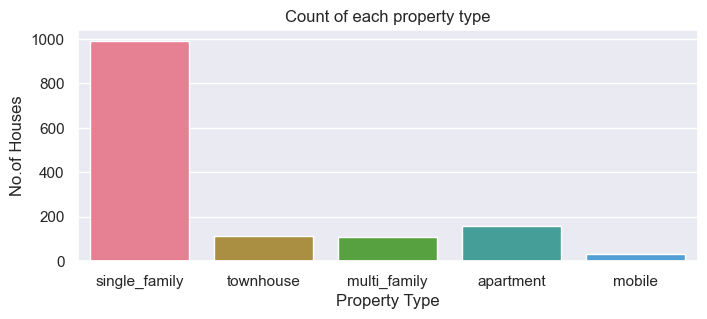

In [62]:
# Plot bar plot for 'type'
plt.figure(figsize=(8,3))
sns.countplot(x=df['type'])  #, palette="Set2"
plt.xlabel("Property Type")
plt.ylabel("No.of Houses")
plt.title("Count of each property type")
plt.show()

Most of our data consists of `single_family` house which describes our training model could be imbalance and we should take this imbalance into account to correctly predict the `sale_price` of other house types. 

### 2.2. Bed, Bath, Garage, Story 

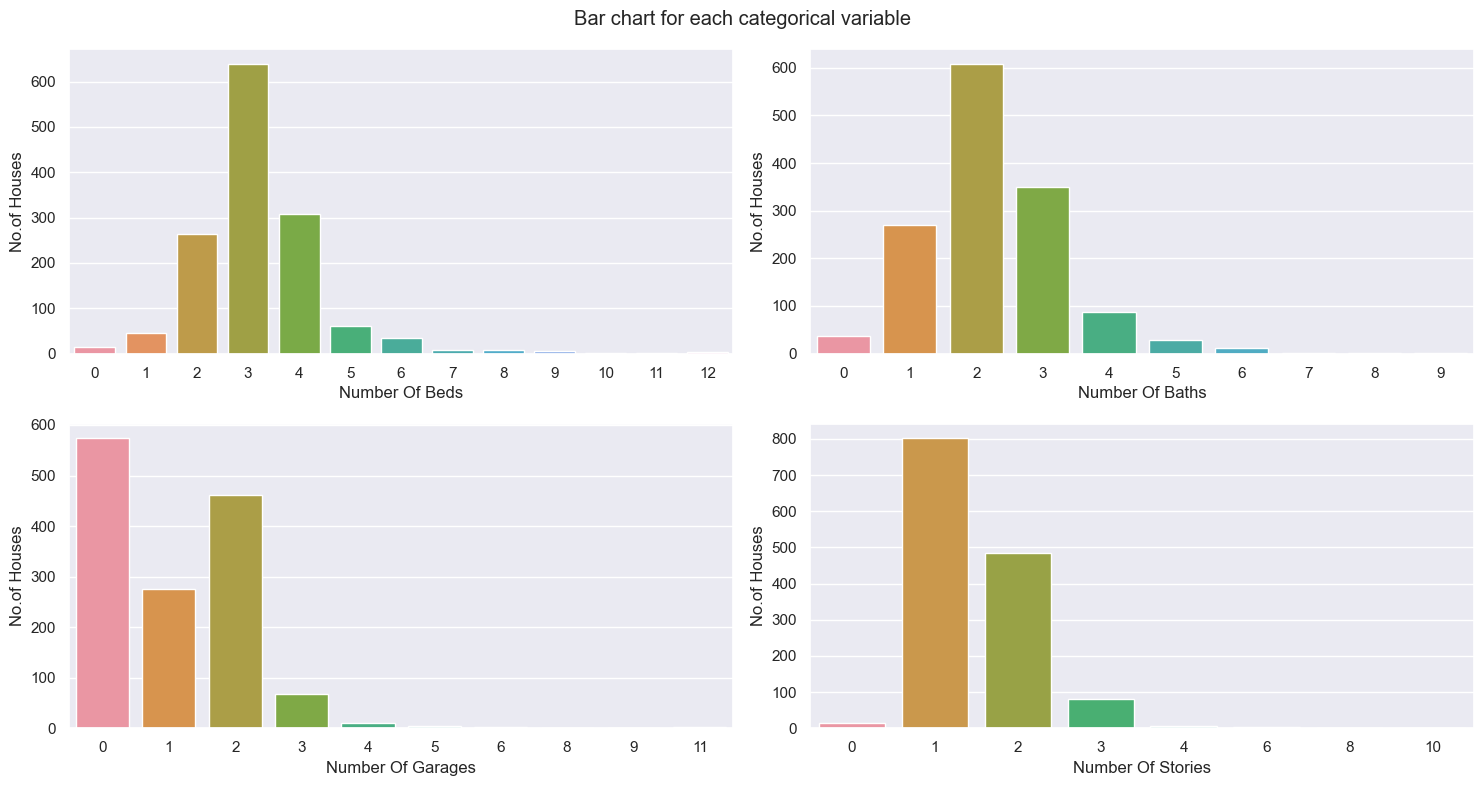

In [63]:
# Plot bar plot for Bed, Bath, Garage, Story
features = ['number_of_beds','number_of_baths','number_of_garages','number_of_stories']
def_Draw_Countplot_Univariate(df, features, nrows=2, ncols=2)

***Insights***
- These Countplots gives us show the distribution of number of different set of **Bedrooms, Bathrooms, Garages and Stories** numbers. 
- Over the entire dataset, we could interpret on average a house has **2-4 bedrooms, 1-3 Bathrooms, 0-2 Garages and 1-2 Stories** in the respective features.
- At this point, the **Bedrooms > 6 , Bathrooms > 5, Garages > 3, Stories > 3 & < 0** could be potential errors and can be removed for preprocessing.  

### 2.3. Distrubution of houses over the different states

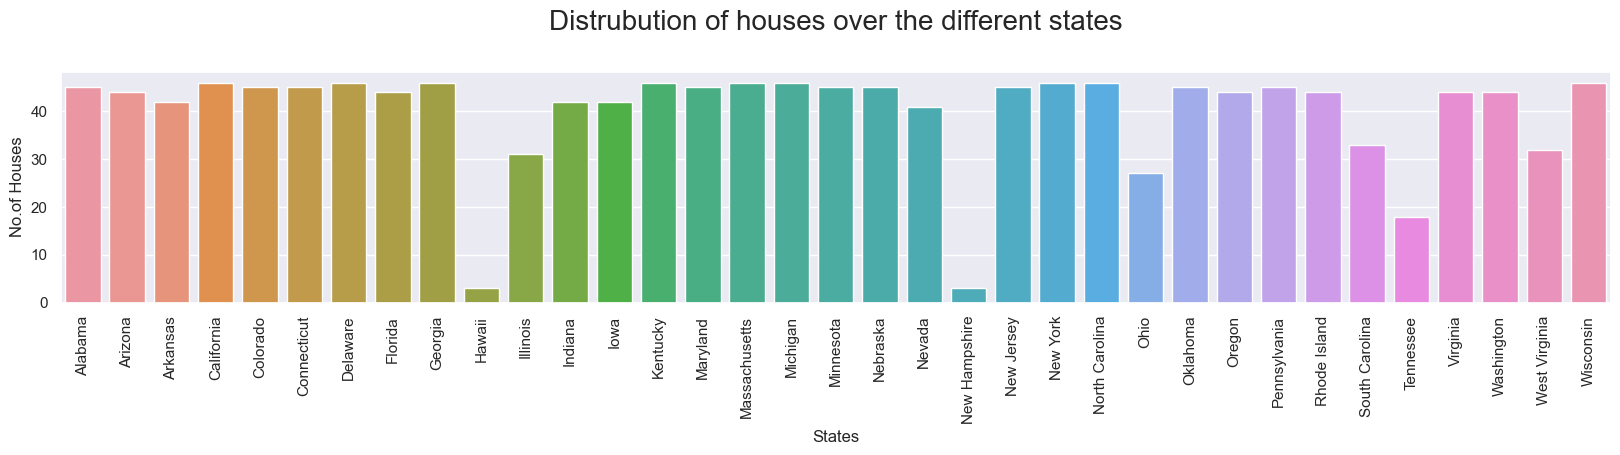

In [64]:
graph_data = df.groupby(by='state').size()

graph_data = pd.DataFrame({
    'state':graph_data.index,
    'count':graph_data.values
})

plt.figure(figsize=(20,3)) 
sns.barplot(data=graph_data,x='state',y='count')
plt.title("Distrubution of houses over the different states",fontsize=20,pad=30)
plt.xlabel("States")
plt.ylabel("No.of Houses")
plt.xticks(rotation=90)
plt.show()

***Insights***
- State of `Hawaii`, `New Hampshire` and `Tennessee` seems to have lower houses located and other states have atleast 35 houses each which is good distribution for the data.

### 2.4. The rest of categorical variables

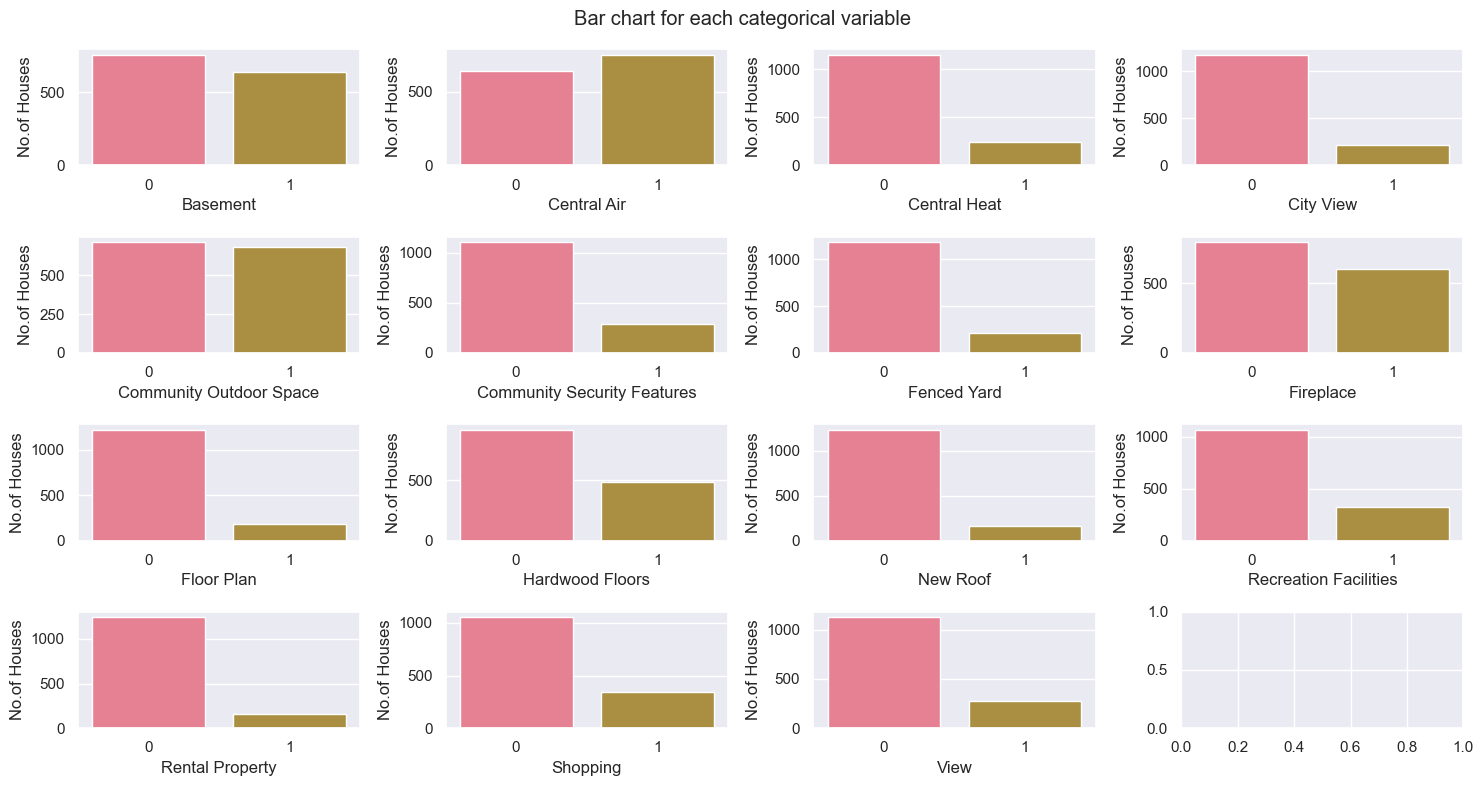

In [65]:
# Draw
features = ['basement','central_air','central_heat','city_view','community_outdoor_space','community_security_features','fenced_yard',
            'fireplace', 'floor_plan', 'hardwood_floors', 'new_roof', 'recreation_facilities', 'rental_property', 'shopping', 'view']
def_Draw_Countplot_Univariate(df, features, nrows=4, ncols=4)

***Insights***
- from the above graphs, this can be interpreted that `Basement`, `Central_Air`,`Community_Outdoor_Space`, `Fireplace` and `Hardwood_Floors` might impact the model as other columns do have an equal categorical distribution and it will be hard to say they will impact the model learning as there is insufficient rows with those columns as 1.

## 3. Visualize the relationship between features and sale_price

### 3.1. House Price vs. Property Type

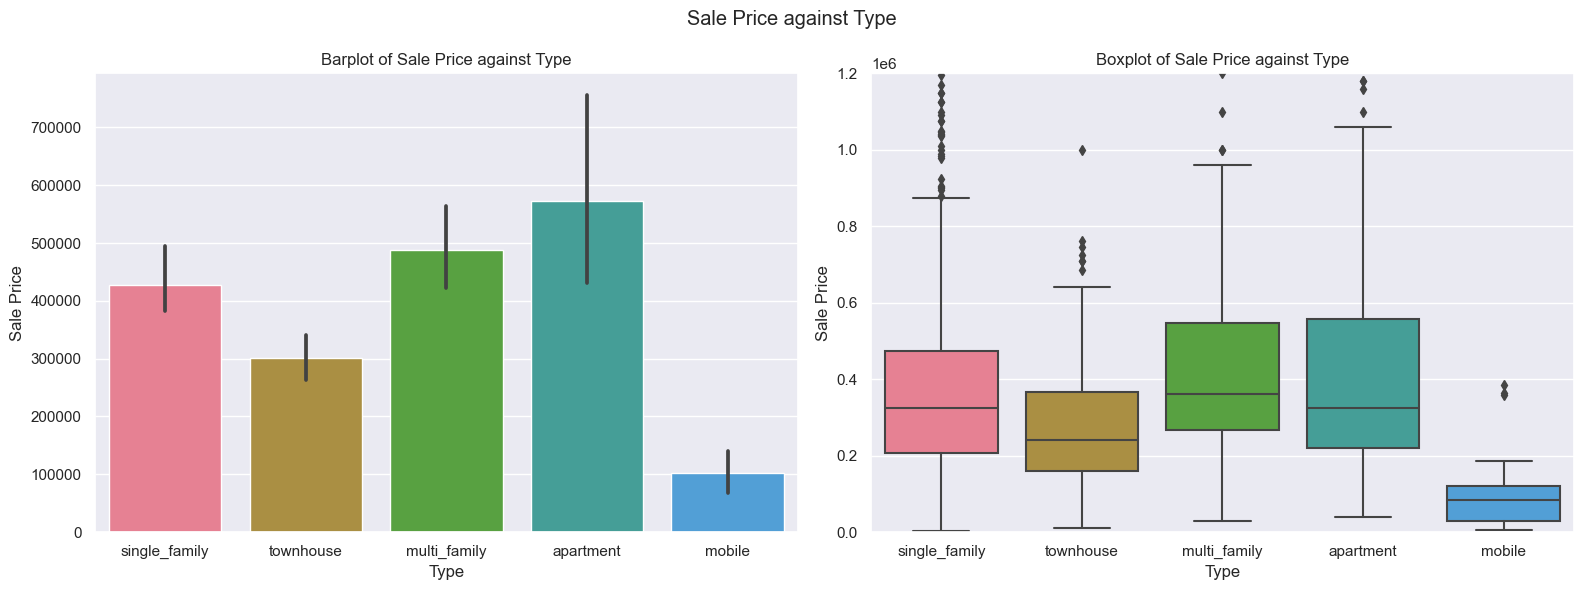

In [66]:
def_Draw_Barplot_Boxplot_Bivariate(df, 'sale_price', 'type', ylim=(0, 1200000))

***Insights***
- Above is a Bar Graph and Box plot side by side in comparison for **Sale Price** vs **Each House Type** in the dataset. In terms of selling, the apartment holds the price market in this dataset, followed by Multi-family and Single Family. 
- This is a great insight for a potential builder to recognize potential selling house type 

### 3.2. House Price vs. City, State

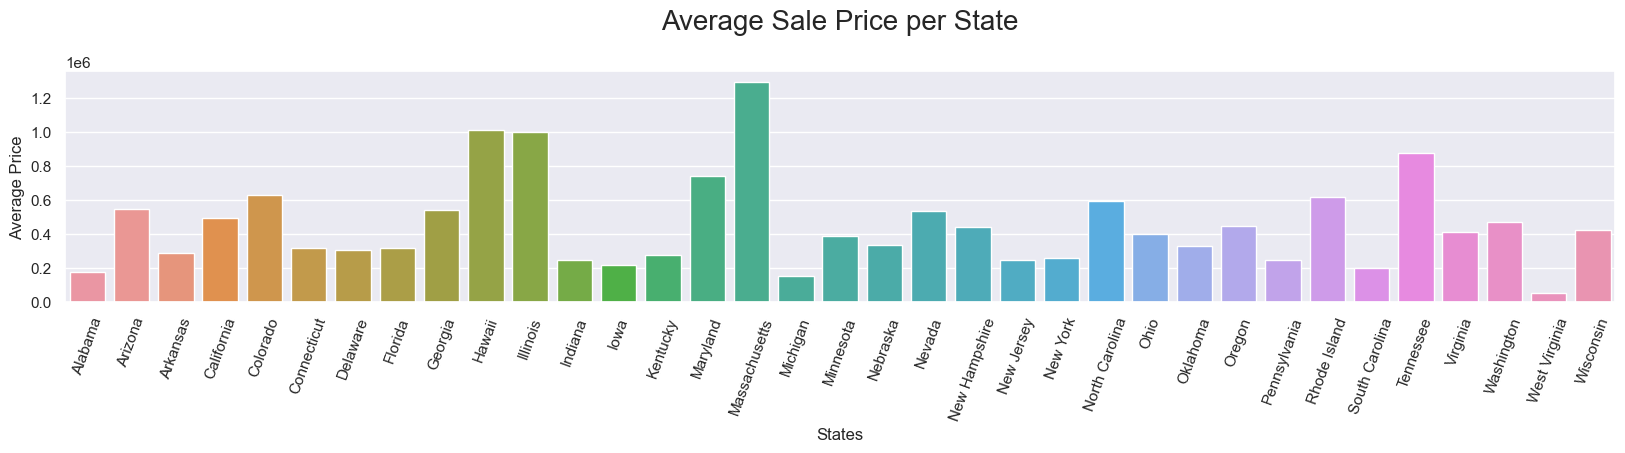

In [67]:
# Plot Bar Plot of Sale Price by State
graph_data = df.groupby(by='state')['sale_price'].mean()

graph_data = pd.DataFrame({
    'state':graph_data.index,
    'avg_price':graph_data.values
})

plt.figure(figsize=(20,3)) 
sns.barplot(data=graph_data,x='state',y='avg_price')
plt.title("Average Sale Price per State",fontsize=20,pad=30)
plt.xlabel("States")
plt.ylabel("Average Price")
plt.xticks(rotation=70)
plt.show()

***Insights***
- This represents average price of a house in each state. This could be really useful from client perspective.

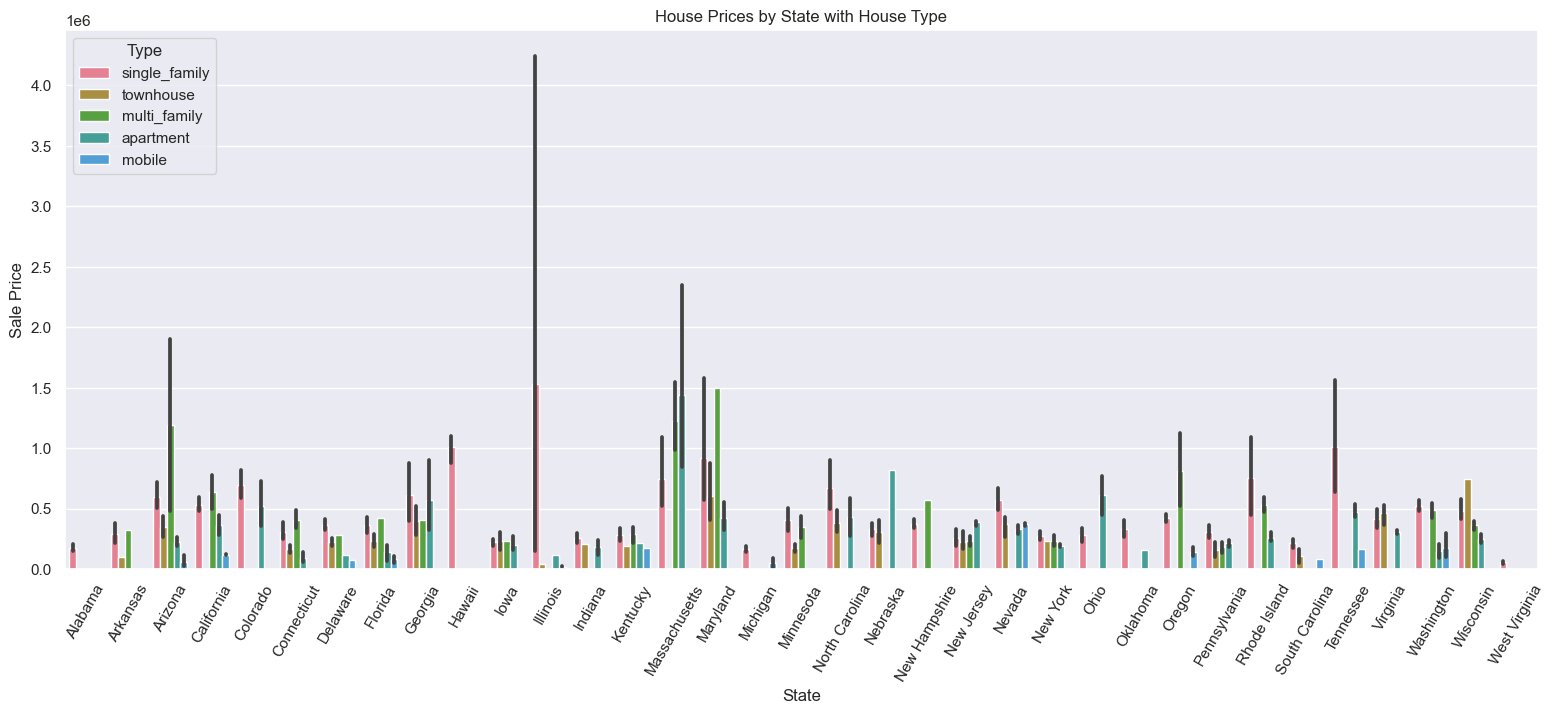

In [68]:
plt.figure(figsize=(19, 7))
sns.barplot(x='state', y='sale_price', hue='type', data=df)
plt.xticks(rotation=60) 
plt.title('House Prices by State with House Type')
plt.xlabel('State')
plt.ylabel('Sale Price')
plt.legend(title='Type')
plt.show()

***Insights***
- This represents average price of a house in each state divided by each house type. This could be really useful from client perspective.

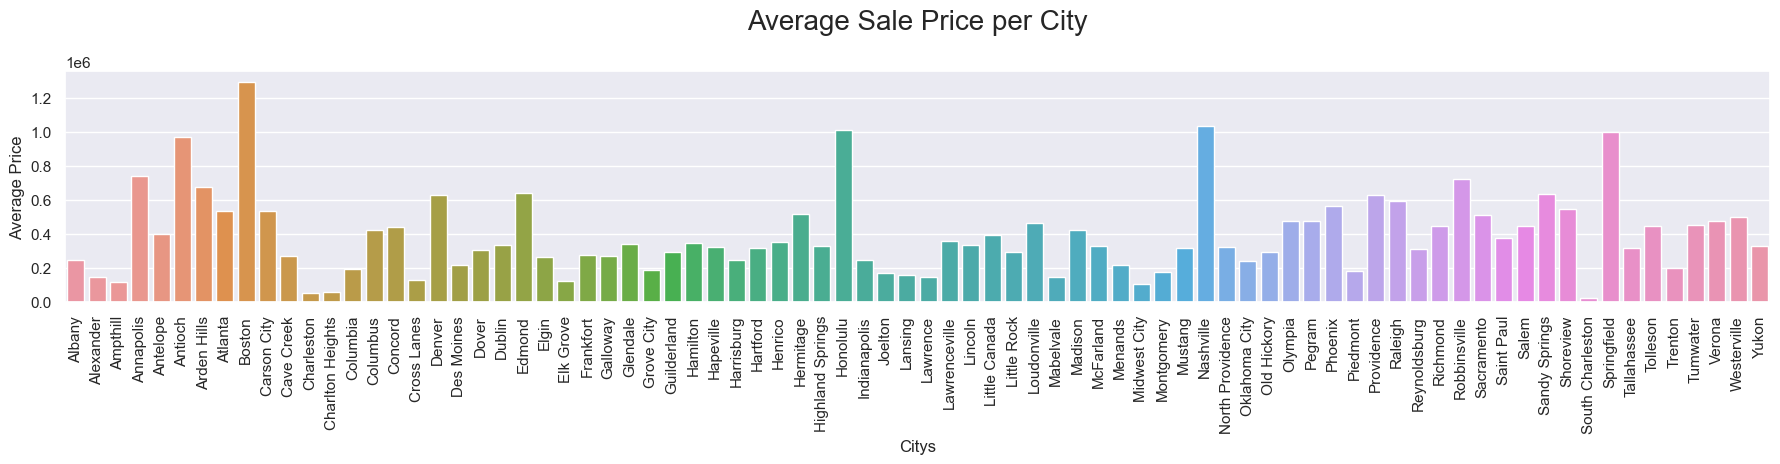

In [69]:
# Plot Bar Plot of Sale Price by City
graph_data = df.groupby(by='city')['sale_price'].mean()

graph_data = pd.DataFrame({
    'city':graph_data.index,
    'avg_price':graph_data.values
})

plt.figure(figsize=(22,3)) 
sns.barplot(data=graph_data,x='city',y='avg_price')
plt.title("Average Sale Price per City",fontsize=20,pad=30)
plt.xlabel("Citys")
plt.ylabel("Average Price")
plt.xticks(rotation=90)
plt.show()

***Insights***
- `Client perspective` to show the pricing market for houses for a potential buyer open to relocate for each city. **Boston, Honolulu, Nashville and Springfield** cities seems to have high priced housing with an average $1 Milliion house sale_price. 

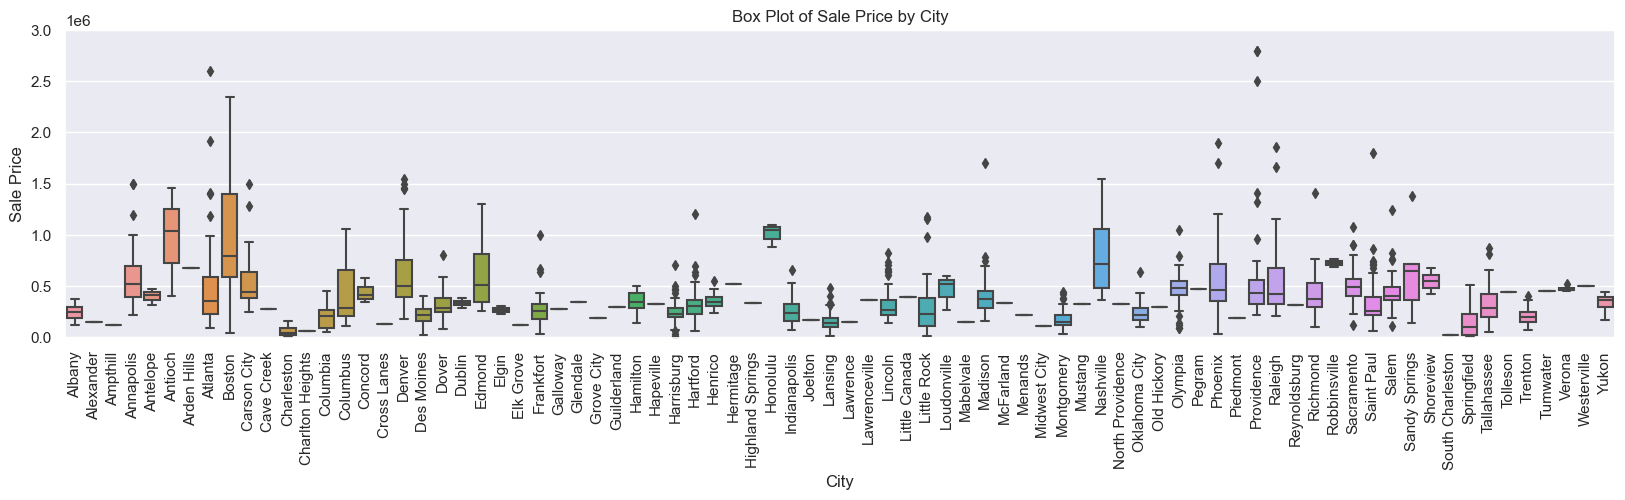

In [70]:
#ticks will be alphabetically organised
data_for_graph = df[['city','sale_price']].sort_values(by='city')

# Plot Box Plot of Sale Price by City
plt.figure(figsize=(20, 4))
ax = sns.boxplot(x='city', y='sale_price', data=data_for_graph)
ax.set_ylim(-10000, 3000000) 
plt.xticks(rotation=90) 
plt.title('Box Plot of Sale Price by City')
plt.xlabel('City')
plt.ylabel('Sale Price')
plt.show()

***Insights***
- This graph points towards the outliers or large sale price per city apart from normal distribution of sale_price data. Our top expensive cities **Boston, Honolulu, Nashville and Springfield** seems to have less outliers 

### 3.3. House Price vs. Bed, Bath, Garage, Story

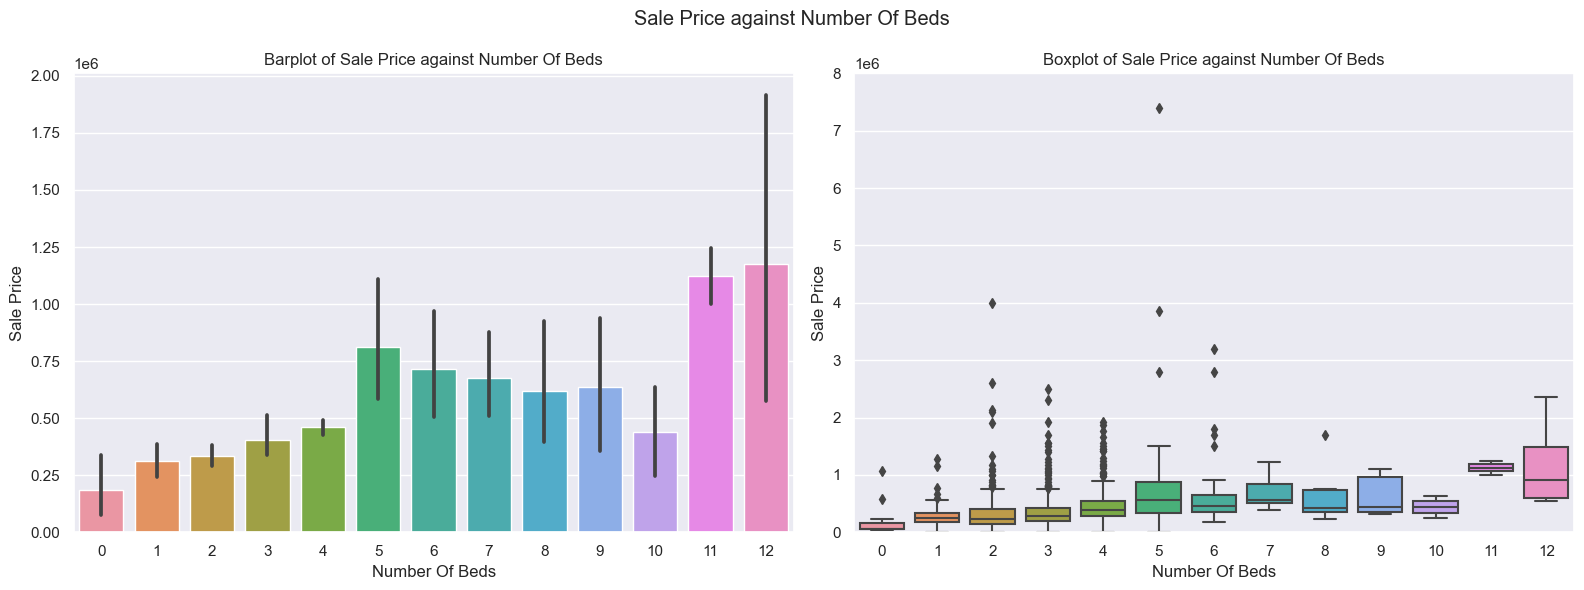

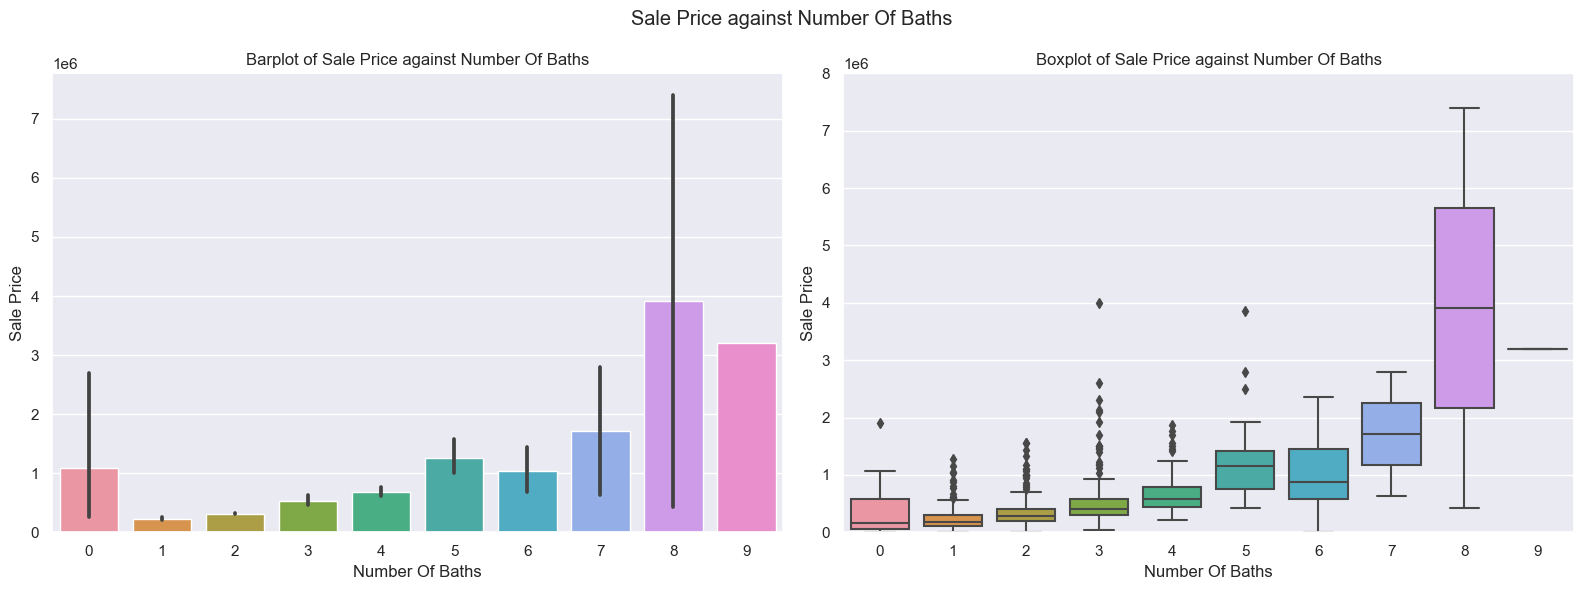

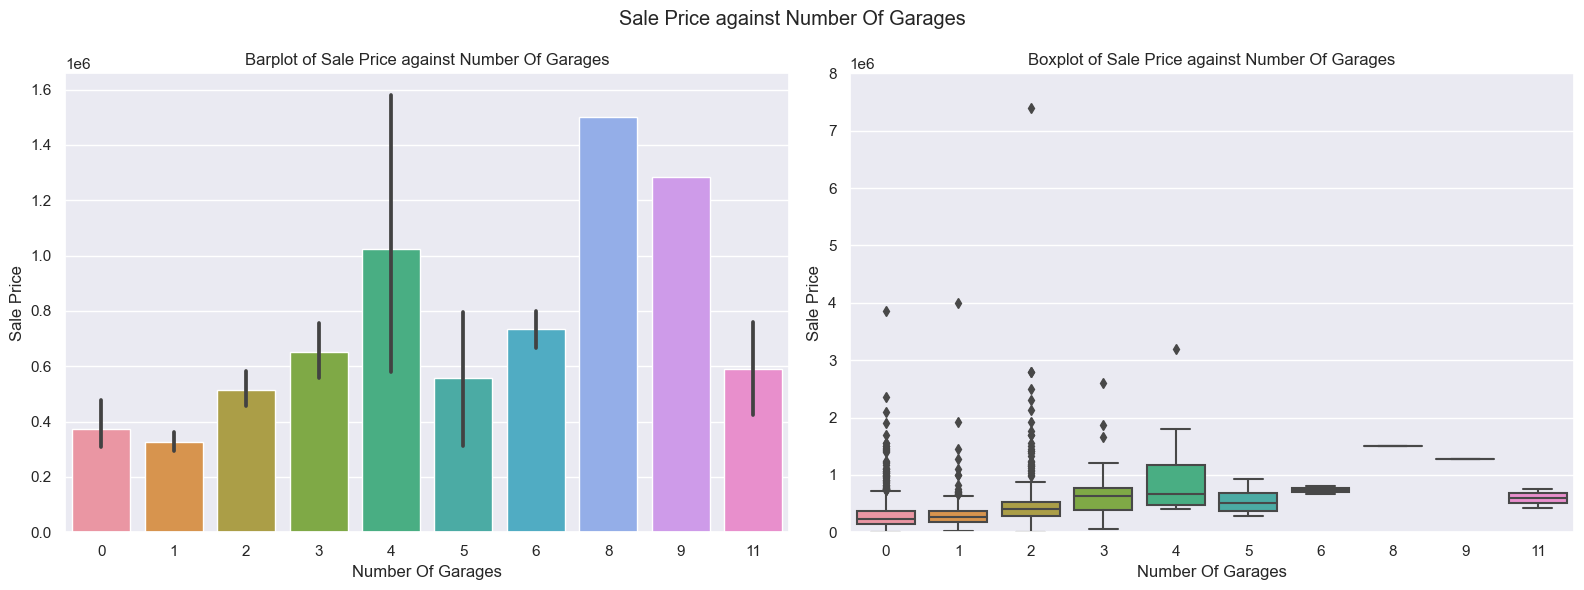

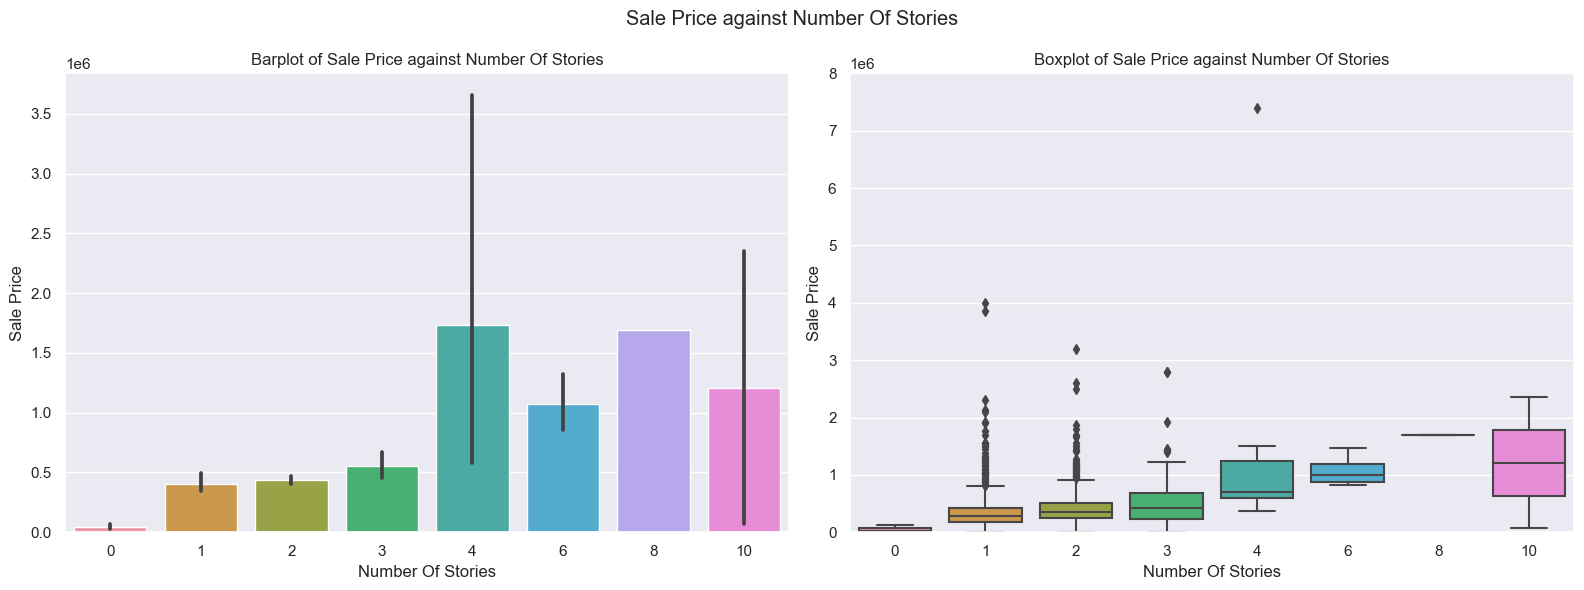

In [71]:
features = ['number_of_beds','number_of_baths','number_of_garages','number_of_stories']

for feature in features:
    def_Draw_Barplot_Boxplot_Bivariate(df, 'sale_price', feature, ylim=(0, 8000000))

***Insights***
- Over the entire dataset, we could interpret on average a houses with **5 bedrooms, 5 Bathrooms, 3 Garages and 4 Stories** comes in expensive market which is valid and we could also see unusual values ( outliers) for each category such as **10 Storeys** which could be an error this could happen might be if its a building or housing complex.
- At this point, the **Bedrooms > 6 , Bathrooms > 5, Garages > 3, Stories > 3 & < 1** could be potential errors and can be removed for preprocessing.  

### Pairplotting Numerical Columns for Correlation

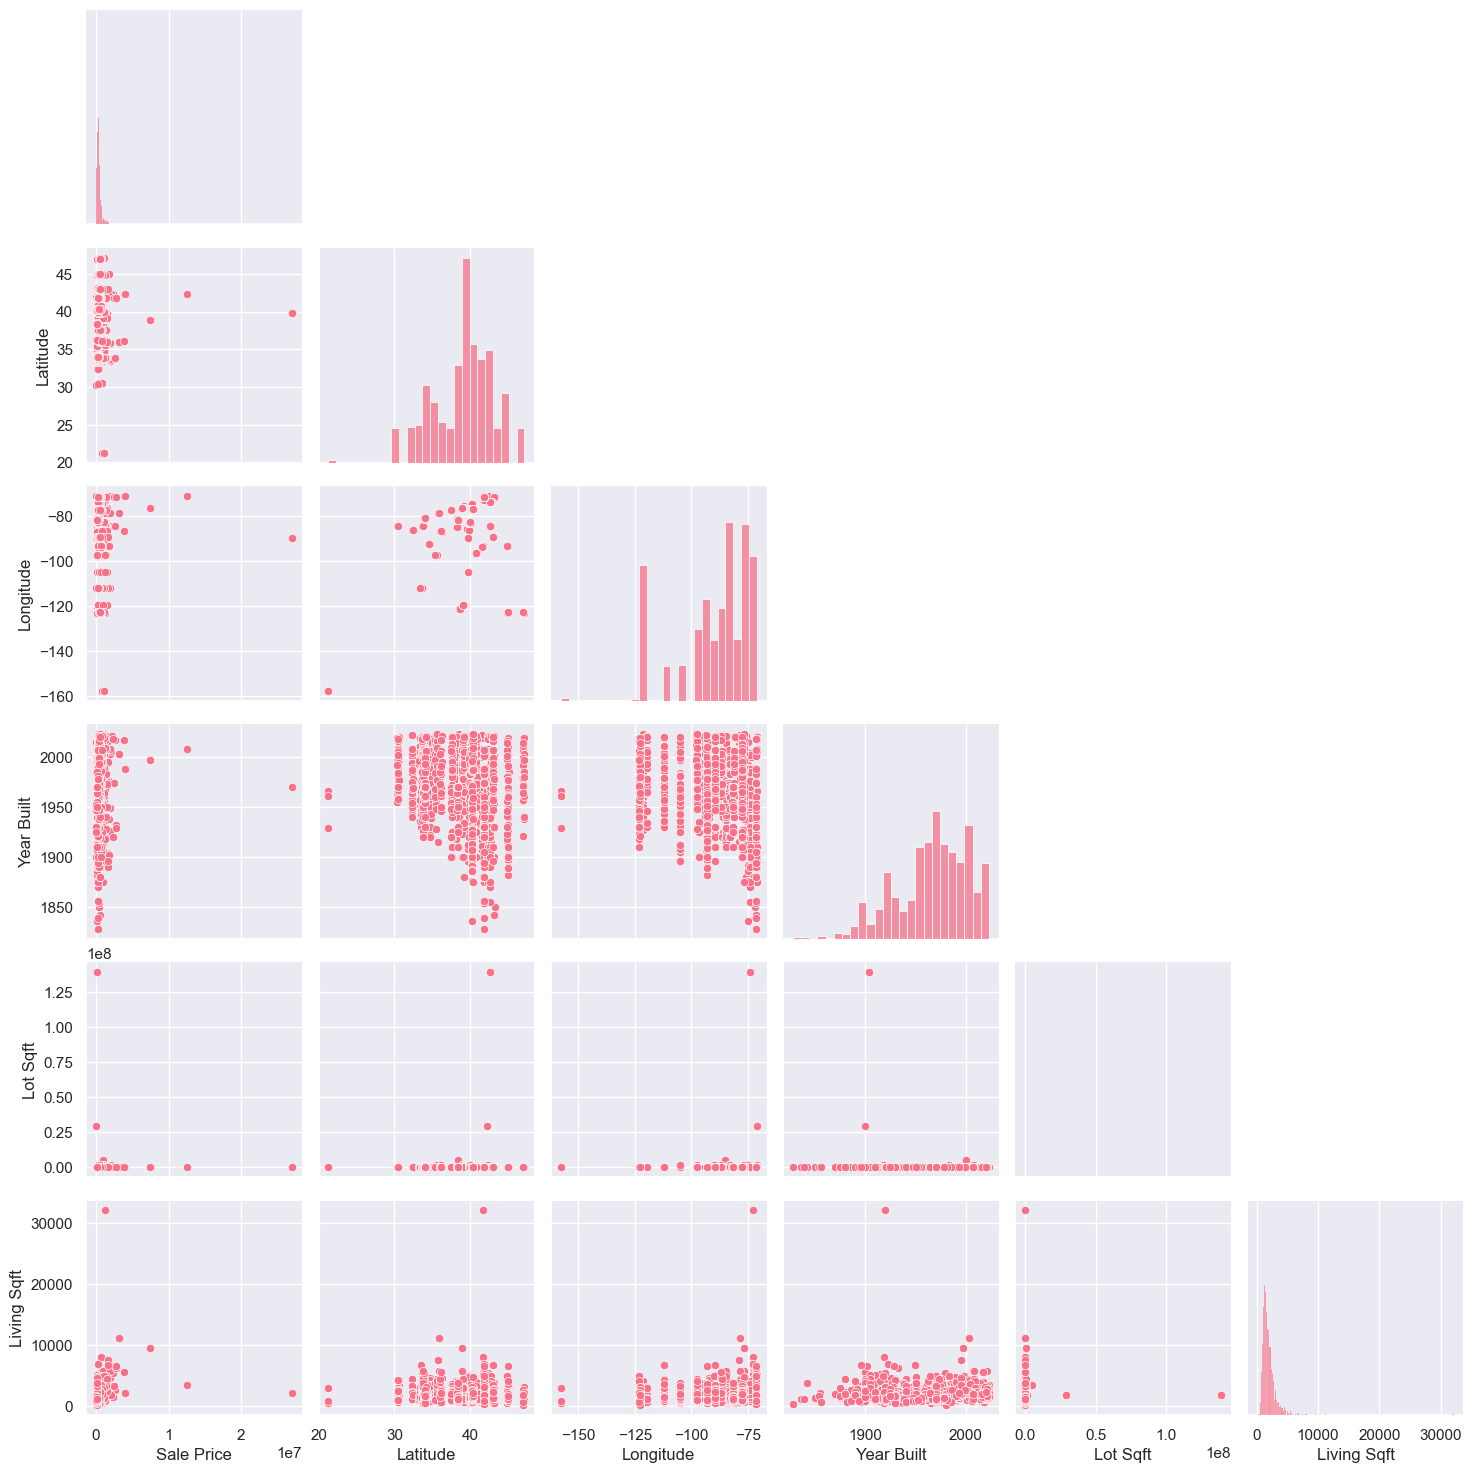

In [72]:
#Let's use seaborn's `pairplot` to informally check if there is linearity between the numerical variables
# Then take a closer look later

new_column_names = [col.replace('_', ' ').title() for col in df[numerical_cols].columns]
df_titles = df[numerical_cols].copy()
df_titles.columns = new_column_names

sns.pairplot(data=df_titles, corner=True)
plt.show()

***Insights***
- **No Strong Correlation** can be detected from the above graphs as points do not seem to be tightly clustered around a straight line rather in corners or around X-axis
- **Outlier Detection** can be seen in **Sale price, Lot SQFT, Longitude, Latitude, Year Built** from each of the respective graphs
- **Userful information** would be knowing most of the house built cluster is from 1900-2000, the houses' map interaction leans towards > 30 latitude and -125 to -75 longitude

### 3.5. House Price vs. Living SQFT

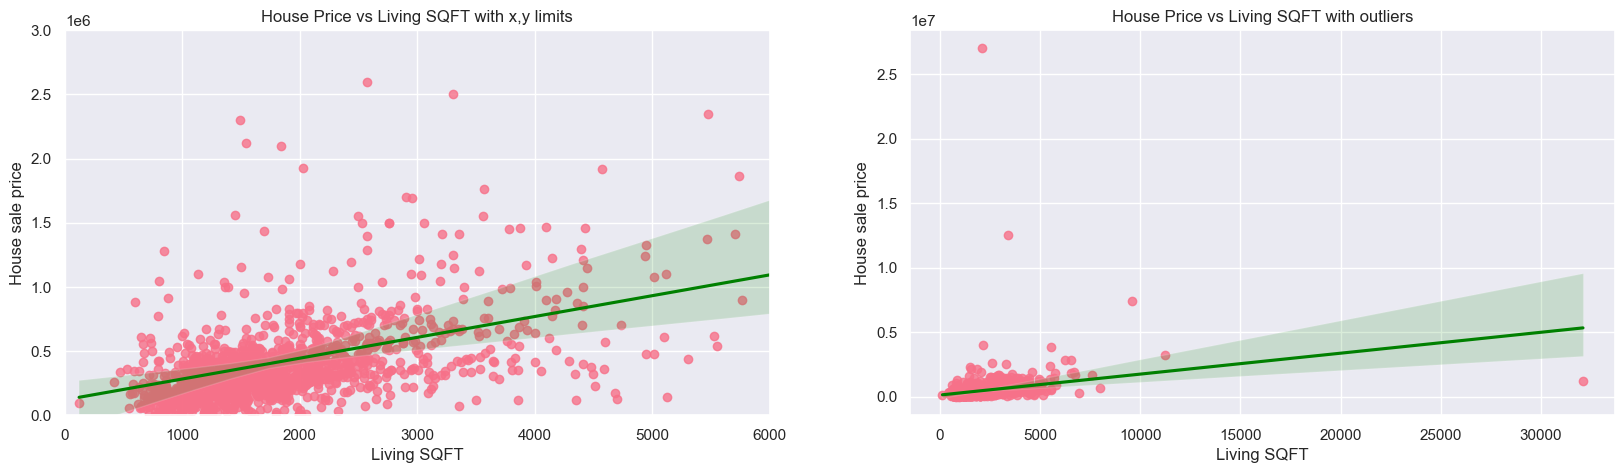

In [73]:
# Plot scatter plot Living SQFT vs. Sale Price

fig,ax = plt.subplots(figsize=(20,5),nrows=1,ncols=2)

sns.regplot(x=df['living_sqft'],y=df['sale_price'],ax=ax[0], line_kws={'color':'green'})
ax[0].set_title("House Price vs Living SQFT with x,y limits")
ax[0].set_xlabel("Living SQFT")
ax[0].set_ylabel("House sale price")

# Set the scale for x and y axes
ax[0].set_xlim(0, 6000) 
ax[0].set_ylim(0, 3000000) 


sns.regplot(x=df['living_sqft'], y=df['sale_price'], ax=ax[1], line_kws={'color':'green'})
ax[1].set_title("House Price vs Living SQFT with outliers")
ax[1].set_xlabel("Living SQFT")
ax[1].set_ylabel("House sale price")

plt.show()

***Insights***
- Fig 1 : The `sold_price` and `living_sqft` exhibits some linear behaviour and our most of the data lies within IQR.
- Fig 2 : There are few outliers that can be detected from the second graph with huge `house_sale` and `living_SQFT` values which can affect the scoring function of model in the long run.

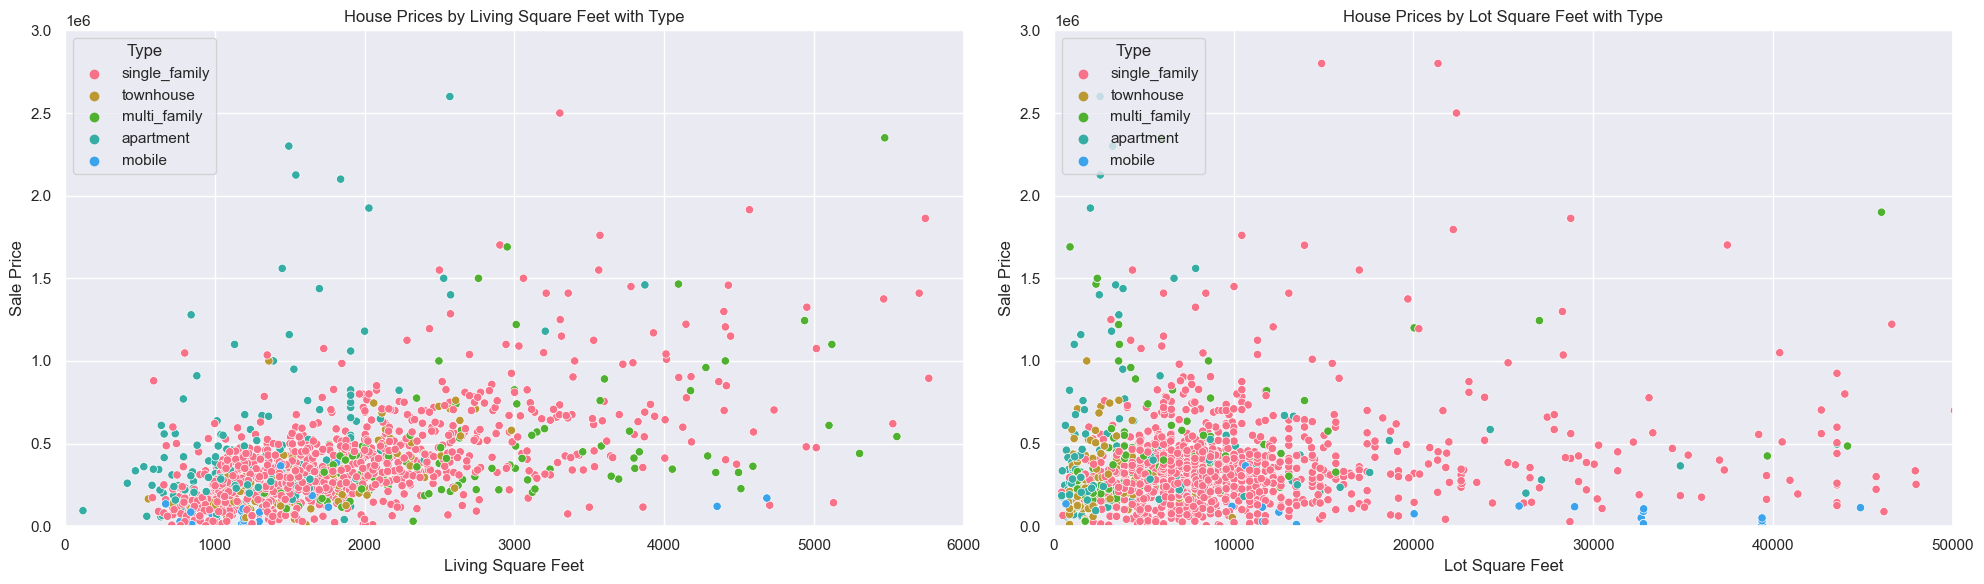

In [74]:
# Create subplots
fig, axes = plt.subplots(figsize=(20, 6), ncols=2)

# Scatter plot 1: Living Square Feet vs Sale Price
sns.scatterplot(x='living_sqft', y='sale_price', hue='type', data=df, ax=axes[0])
axes[0].set_title('House Prices by Living Square Feet with Type')
axes[0].set_xlabel('Living Square Feet')
axes[0].set_ylabel('Sale Price')
axes[0].set_xlim(0, 6000) 
axes[0].set_ylim(0, 3000000) 
axes[0].legend(title='Type', loc='upper left') 

# Scatter plot 2: Lot Square Feet vs Sale Price
sns.scatterplot(x='lot_sqft', y='sale_price', hue='type', data=df, ax=axes[1])
axes[1].set_title('House Prices by Lot Square Feet with Type')
axes[1].set_xlabel('Lot Square Feet')
axes[1].set_ylabel('Sale Price')
axes[1].set_xlim(0, 50000) 
axes[1].set_ylim(0, 3000000) 
axes[1].legend(title='Type', loc='upper left') 

plt.tight_layout()
plt.show()

***Insights***
- The average houses lie in range of **600 - 3000 Living SQFT** and **Lot SQFT is > 0 to 15000** which should be more than the Living SQFT generally in real world.
- The type **single family** seems popular over the location and this could be an amazing client insight to choose house type from. 

### 3.7 House Price vs. Year Built

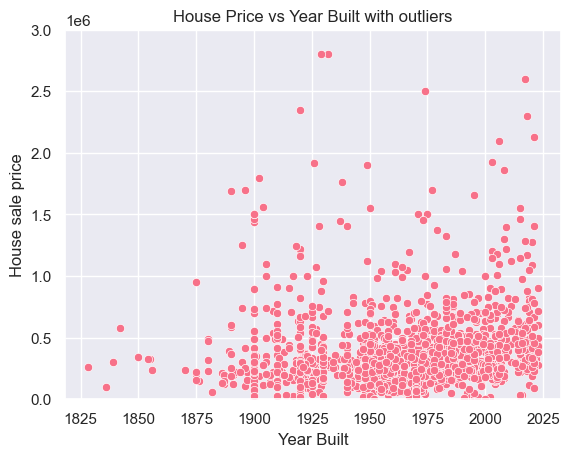

In [75]:
# scatter plot Year Built vs. Sale Price

sns.scatterplot(x=df['year_built'],y=df['sale_price'])
plt.title("House Price vs Year Built with outliers")
plt.xlabel("Year Built")
plt.ylabel("House sale price")

# plt.xlim(1800, 2050) 
plt.ylim(0, 3000000) 

plt.show()

#### Comment:
- This graph could tell us that most of houses in the data is built between 1900-2020 and the relationship is not linear
- A `house` built in `1900` and `2000` could have the same price and `year_built` alone cannot explain the relationship and would require more insight.

### 3.8. Heatmap to show Correlation between the numerical features

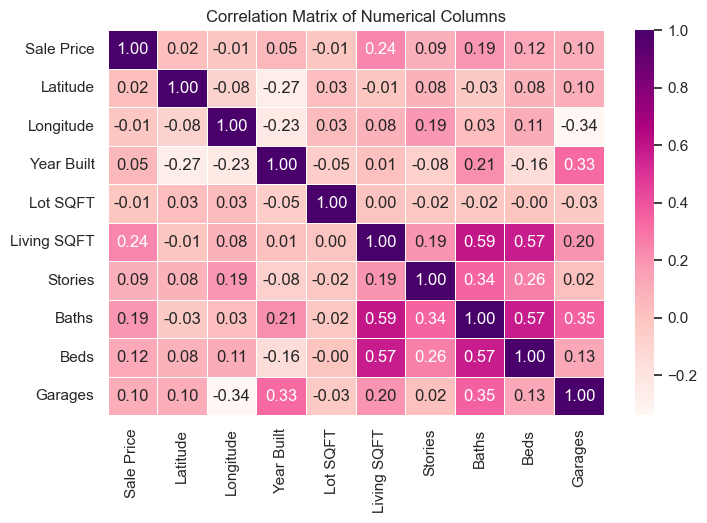

In [76]:
corr_matrix = df[['sale_price','latitude', 'longitude', 'year_built', 'lot_sqft', 'living_sqft', 'number_of_stories',
       'number_of_baths', 'number_of_beds', 'number_of_garages']].corr()

#human-readable ticks for heatmap
ticks = ['Sale Price', 'Latitude', 'Longitude', 'Year Built', 'Lot SQFT', 'Living SQFT','Stories','Baths','Beds','Garages']

plt.figure(figsize=(8,5))
sns.heatmap(corr_matrix,annot=True,cmap='RdPu',fmt='.2f',linewidths=0.7,xticklabels=ticks,yticklabels=ticks)
plt.xticks(rotation=90)
plt.title("Correlation Matrix of Numerical Columns")
plt.show()

#### Comment:
Insights into correlation map, 
- The **Living SQFT** has a large impact on **Sale_price** in comparison to all other variables, followed by **Baths** and **Garages**
- Potentially, **Longitude** and **Lot SQFT** has a negative correlation with our target variable which directs towards the decrease in sale price with an increment with these values

### 3.9.  Interactive Map to visualize data by geographical location

In [77]:
import plotly.express as px

fig = px.scatter_mapbox(df[df['sale_price']<2000000], lat="latitude", lon="longitude", color="sale_price", size="sale_price",
                        color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10,
                        mapbox_style="carto-positron")
fig.update_layout(title="House Prices less than $2M Based on Location", width=1000, height=600)
fig.show()

***Insights***
- This interactive map displays homes that were sold for less than $2 million. **Every dot on the map represents a house, and the size and color of the dot represent the house's sale price.** House prices based on latitude and longitude coordinates are displayed in this scatter plot. 
- **Builder/Seller Perspective** : This graph could be a great way to enhance user experience of the client and giving information in real time.

# _______________
# G - Outlier Handling

In [78]:
# Genercal outlier removing:

for col in ['sale_price','lot_sqft', 'living_sqft', 'year_built', 'latitude', 'longitude']:
    df = def_Remove_Outliers(df, col, threshold=2) 
    
# reset index
df = df.reset_index(drop=True)

In [79]:
df.shape

(1155, 28)

In [80]:
# Specific outlier removing:

df = df.drop(df[(df['number_of_beds'].astype('int') > 6)].index)     # Remove 'number_of_beds' > 6
df = df.drop(df[(df['number_of_baths'].astype('int') > 5)].index)    # Remove 'number_of_baths' > 5
df = df.drop(df[(df['number_of_garages'].astype('int') > 3)].index)  # Remove 'number_of_garages' > 3
df = df.drop(df[(df['number_of_stories'].astype('int') < 1) & (df['number_of_stories'].astype('int') > 3)].index)  # Remove 'number_of_stories' > 3,<1
df = df.drop(df[(df['living_sqft'] > 6000)].index)                       # Remove 'living_sqft' >=6000 
# df = df.drop(df[(df['sale_price'] > 500000) & (df['living_sqft'] > 6000)].index) 

In [81]:
df.shape

(1134, 28)

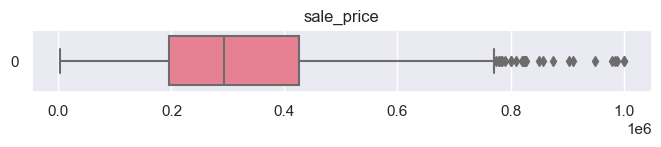

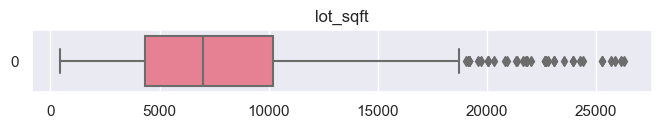

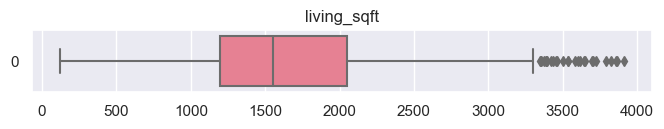

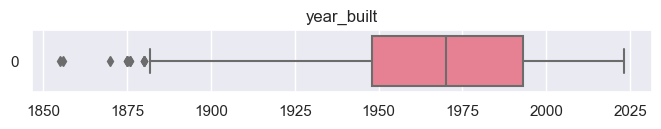

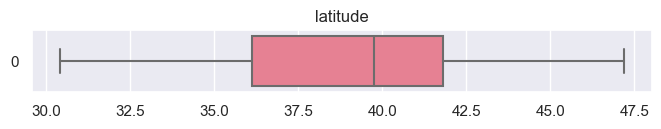

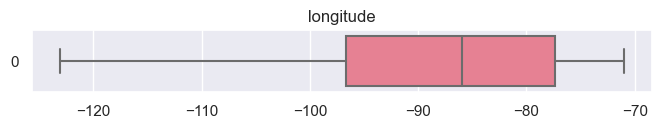

In [82]:
# Draw boxplot again to see after reducing outliers

for col in df.select_dtypes(include=np.number)[['sale_price','lot_sqft', 'living_sqft', 'year_built', 'latitude', 'longitude']]:
    plt.figure(figsize=(8,0.8))
    sns.boxplot(data=df[col], orient='h')
    plt.title(f"{col}")
    plt.show()

In [83]:
df.shape

(1134, 28)

In [84]:
df.dtypes

sale_price                     float64
city                            object
state                           object
latitude                       float64
longitude                      float64
year_built                       int32
type                            object
lot_sqft                         int32
living_sqft                      int32
number_of_stories               object
number_of_baths                 object
number_of_beds                  object
number_of_garages               object
basement                        object
central_air                     object
central_heat                    object
city_view                       object
community_outdoor_space         object
community_security_features     object
fenced_yard                     object
fireplace                       object
floor_plan                      object
hardwood_floors                 object
new_roof                        object
recreation_facilities           object
rental_property          

In [85]:
# Reset index for DataFrame
df = df.reset_index(drop=True)

# Save dataframe into CSV file
df.to_csv("../data/csv_files/cleaned_data_REDUCED_outliers.csv", index=False)

# _______________
# H - Data Splitting

In [86]:
#  Load data
df = pd.read_csv('../data/csv_files/cleaned_data_REDUCED_outliers.csv')

In [87]:
# Define inputs and output variable
X = df.drop(columns='sale_price')
y = df['sale_price']

In [88]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['type'])

In [89]:
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((907, 27), (227, 27), (907,), (227,))

# _______________
# I - DataTransfromation for modelling

## 1. Pipeline for Data  Transformation

* Scale numerical variables
* Format some categorical variables that are string now:
  * OneHotEncoder for 'type' because it is norminal variable and has less categories (5 categories).
  * TargetEncoder for 'city' and 'state': although they are nominal variables, they have too much classes (73 categories in 'city' and 33 categories in 'state'), so using OneHotEncoder is not a good idea when it creates a large number of dummy variables. We will replace categorical values in categorical variables **with the median/mean value of the target variable** (sale price) **by each city/state**. This helps avoid excessive column numbers of dummy variables like OneHotEncoder. Note: After using TargetEncoder, values will be turned out numerical variable, so we should scale them for modelling.

Scikit-Learn also has Target Encoding that has similar above concept but Target MEAN, not MEDIAN
```python
# pip install category_encoders
import category_encoders as ce
target_encoder = ce.TargetEncoder(cols=['city'])   # Initial encoder
df['city_encoded'] = target_encoder.fit_transform(df['city'], df['sale_price'])  # Fit and transform data
df
```
We choose to use Target Encoding manually as below:

In [90]:
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((907, 27), (227, 27), (907,), (227,))

In [91]:
######## Feature Engineering:
######## MANUALLY Replace the categorical values with the median value of the target variable in each category.
######## Computing on training data only  
# Calculate the median value of sale_price for each city and state in the training set
city_median_price = y_train.groupby(X_train['city']).median()
state_median_price = y_train.groupby(X_train['state']).median()

# Map the median values to the training set (# Replace categorical values with the median value of the target variable)
X_train['city'] = X_train['city'].map(city_median_price)
X_train['state'] = X_train['state'].map(state_median_price)

# Check and handle NaN values in the training set (if any)
X_train['city'].fillna(city_median_price.median(), inplace=True)
X_train['state'].fillna(state_median_price.median(), inplace=True)

# Map the median values to the test set
X_test['city'] = X_test['city'].map(city_median_price)
X_test['state'] = X_test['state'].map(state_median_price)

# Check and handle NaN values in the test set (if any)
X_test['city'].fillna(city_median_price.median(), inplace=True)
X_test['state'].fillna(state_median_price.median(), inplace=True)

In [92]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

######## Define numerical and categorical variables needed tranformattion
numerical_cols_X = ['state', 'city', 'year_built', 'latitude', 'longitude', 'lot_sqft', 'living_sqft']
nominal_cols = ['type']


######## Build pipeline
# Pipeline for numerical variables 
numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())  ])

# Pipeline for categorical variables
nominal_pipeline = Pipeline(steps=[
        ('onehot', OneHotEncoder()) ])

# Combine all pipelines with ColumnTransformer
full_pipeline = ColumnTransformer(
    transformers=[
        ('numerical', numerical_pipeline, numerical_cols_X),
        ('nominal', nominal_pipeline, nominal_cols)
    ],
    remainder='passthrough'  # Keep other columns unchanged
)

######## Apply pipeline
X_train_transformed = full_pipeline.fit_transform(X_train, y_train)   # Fit and transform on training data
X_test_transformed = full_pipeline.transform(X_test)                  # Transform on testing data

######## Convert transformed arrays back to DataFrames to match original columns
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=full_pipeline.get_feature_names_out())
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=full_pipeline.get_feature_names_out())

# Ensure that the indices are aligned with y_train and y_test
X_train_transformed_df.index = X_train.index
X_test_transformed_df.index = X_test.index

In [93]:
# print("X_train transformed:")
# X_train_transformed_df.head()

In [94]:
# print("\nX_test transformed:")
# X_test_transformed_df.head()

In [95]:
X_train_transformed_df.shape

(907, 31)

In [96]:
X_test_transformed_df.shape

(227, 31)

In [97]:
X_train.shape[1]

27

In [98]:
X_train_transformed_df.shape[1] 

31

In [99]:
len(nominal_cols)

1

In [100]:
# AUDIT - Checking if number of columns appears correctly after data tranformation pipeline:

print("Number of columns of X before transformation:", X_train.shape[1])
print("Number of columns of X after transformation:", X_train_transformed_df.shape[1])
print("Difference of number of columns of X between before after data tranformation pipeline:",
      X_train_transformed_df.shape[1] - ( X_train.shape[1] + (len(nominal_cols)* df['type'].nunique() -1)))

Number of columns of X before transformation: 27
Number of columns of X after transformation: 31
Difference of number of columns of X between before after data tranformation pipeline: 0


# _______________
# J - Save the data for modelling

In [101]:
# Save to CSV files
X_train_transformed_df.to_csv('../data/csv_files/X_train_transformed.csv', index=False)
X_test_transformed_df.to_csv('../data/csv_files/X_test_transformed.csv', index=False)
y_train.to_csv('../data/csv_files/y_train.csv', index=False)
y_test.to_csv('../data/csv_files/y_test.csv', index=False)